In [1]:
import os
import re
import json
import codecs
import gc
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.neighbors import DistanceMetric
from metric_learn import ITML_Supervised, Covariance, LSML, LSML_Supervised
from sklearn.metrics.pairwise import pairwise_distances as pdist
# import delta
from xgboost import XGBRegressor, plot_importance

from scripts.utils import *
from scripts.readability_functions import *

In [2]:
dir_in_parsed = 'parsed_json_cut'#'parsed_json_cut_chunks'
dir_in_raw = 'json_cut'#'json_cut_chunks'

In [3]:
catalog = pd.read_csv('collection_catalog_full_final.csv', sep=';')
with open('stop3grams.txt', 'r') as f:
    stop3grams = set([s.lower() for s in f.read().splitlines()])

In [4]:
len(stop3grams)

4559

In [5]:
authors = []
book_names = []
book_fbusta_ids = []
book_ids = []
for filename in sorted(os.listdir(dir_in_parsed)):
    with open(os.path.join(dir_in_parsed, filename), 'r') as book:
        fbusta_id = int(filename.split('.')[0])
        book_fbusta_ids.append(fbusta_id)
        book_ids.append(get_book_id(fbusta_id, catalog))
        authors.append(get_author_id(fbusta_id, catalog))
        book_names.append(get_book_name(fbusta_id, catalog))
book_fbusta_ids = np.array(book_fbusta_ids)
book_names = np.array(book_names)
authors = np.array(authors)
book_ids = np.array(book_ids)

In [6]:
gc.collect()

20

In [7]:
len(authors)

621

In [8]:
groups = pd.Series(authors).value_counts()
singles = np.array(groups[groups==1].index)
singles

array([ 14,  36,  31,   7, 107])

In [9]:
authors = np.array([a for a in authors if a not in singles])
len(authors)

616

In [10]:
pd.Series(authors).value_counts().value_counts()

5    49
4    45
3    19
6    16
2     7
9     1
8     1
7     1
dtype: int64

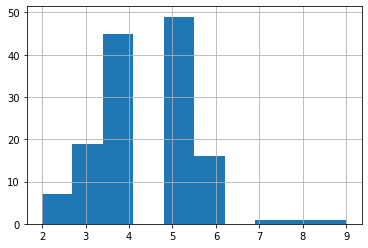

In [11]:
%matplotlib inline
pd.Series(authors).value_counts().hist()

In [18]:
SAME_BOOK = 4
SAME_AUTHOR = 3
SAME_AGE = 2
LINKS_BOOKS = 1
LINKS_AUTHORS = 1
OTHER = 0

In [20]:
rel_matrix = pd.DataFrame(np.zeros((catalog.shape[0], catalog.shape[0])))
rel_matrix.columns = catalog['book_id']
rel_matrix.index = rel_matrix.columns

In [21]:
%%time
for i in range(catalog.shape[0]):
    row = catalog.iloc[i]
    rel_matrix.iloc[i, i] = SAME_BOOK
    for j in range(i+1, catalog.shape[0]):
        row2 = catalog.iloc[j]
        assert row2.book_id.item() == rel_matrix.iloc[j].name
        if rel_matrix.iloc[i, j] != 0:
#             print(i, j, 'zaneto', rel_matrix.iloc[i, j])
            continue
        if row.author_id.item() == row2.author_id.item():
            rel_matrix.iloc[i, j] = SAME_AUTHOR
            rel_matrix.iloc[j, i] = SAME_AUTHOR
#             print(i, j, 'author', rel_matrix.iloc[i, j])
        elif abs(row.year.item() - row2.year.item()) < 10:
            rel_matrix.iloc[i, j] = SAME_AGE
            rel_matrix.iloc[j, i] = SAME_AGE
#             print(i, j, 'age', rel_matrix.iloc[i, j])
        elif str(row.book_id) in str(row2.book_com_links).split('_'):
            rel_matrix.iloc[i, j] = LINKS_BOOKS
            rel_matrix.iloc[j, i] = LINKS_BOOKS
#             print(i, j, 'books', rel_matrix.iloc[i, j])
        elif str(row.author_id) in str(row2.author_com_links).split('_'):
            rel_matrix.iloc[i, j] = LINKS_AUTHORS
            rel_matrix.iloc[j, i] = LINKS_AUTHORS
#             print(i, j, 'authors', rel_matrix.iloc[i, j])
#         else:
#             print(i, j, 'none', rel_matrix.iloc[i, j])

CPU times: user 2min 9s, sys: 87 ms, total: 2min 9s
Wall time: 2min 9s


In [22]:
def ndcg_m(dists, book_ids, catalog=catalog, verbose=False):
    result = []
    for col in dists:
        from_book_id = book_ids[col]
        p = (rel_matrix[from_book_id] > 0).sum() - 1
        cur_book_info = catalog[catalog['book_id'] == from_book_id]
        closest = book_ids[dists[col].argsort()][1:p+1]
        dcg = 0
        for i, book_id in enumerate(closest):
            book_info = catalog[catalog['book_id'] == book_id]
            if book_id == cur_book_info['book_id'].item():
                rel = SAME_BOOK
            elif cur_book_info['author_id'].item() == book_info['author_id'].item():
                rel = SAME_AUTHOR
            elif abs(cur_book_info['year'].item() - book_info['year'].item()) < 10:
                rel = SAME_AGE
            elif str(book_id) in str(cur_book_info['book_com_links'].item()).split('_'):
                rel = LINKS_BOOKS
            elif str(book_info['author_id'].item()) in str(cur_book_info['author_com_links'].item()).split('_'):
                rel = LINKS_AUTHORS
            else:
                rel = OTHER
            dcg += (2 ** rel - 1) / np.log2(i+2)
        
        i = 0
        idcg = 0
        true_rel_row = sorted(rel_matrix[from_book_id].value_counts().items(), reverse=True)
        k, v = true_rel_row[0]
        true_rel_row[0] = (k, v-1)
        for k, v in true_rel_row:
            if not k:
                break
            for j in range(v):
                i += 1
                idcg += (2 ** k - 1) / np.log2(i+1)
        assert p == i
        result.append(dcg / idcg)
        
    return result

In [23]:
# %%time
# ndcg_m(pd.DataFrame(dist_xgb_train), book_ids_train, catalog)

### Train test grouped split

# 3 pos

In [21]:
%%time

data = []
for filename in sorted(os.listdir(dir_in_parsed)):
    with open(os.path.join(dir_in_parsed, filename), 'r') as book:
        fbusta_id = int(filename.split('.')[0])
        if get_author_id(fbusta_id, catalog) not in singles:
            data.append(book.read())
data = np.array(data)
print(len(data))

616
CPU times: user 786 ms, sys: 117 ms, total: 903 ms
Wall time: 901 ms


In [22]:
idx_train, idx_test = train_test_split(data, authors, return_idx=True, mod='s')
data_train, y_train, data_test, y_test = data[idx_train], authors[idx_train], data[idx_test], authors[idx_test]
x_train_tri, cv_tri_grams = count_n_grams(data_train, n=3, stopgrams=stop3grams, max_features=5000) #5700
x_test_tri = cv_tri_grams.transform(data_test)
# tri_grams = normalize(tri_grams, norm='l1')

test_fraction: 0.5454545454545454


In [23]:
x_train_tri

<336x4392 sparse matrix of type '<class 'numpy.int64'>'
	with 571378 stored elements in Compressed Sparse Row format>

In [29]:
# del data
# gc.collect()

In [30]:
# df = pd.DataFrame(tri_grams.todense())
# df.columns = sorted(cv_tri_grams.vocabulary_)

### 3pos + xgb

In [31]:
x_train_tri = normalize(x_train_tri, norm='l1').todense()
x_test_tri = x_test_tri.todense()
book_ids_train, book_ids_test = book_ids[idx_train], book_ids[idx_test]

### Удобочитаемые фичи

#### % диалогов

In [33]:
dia_frac = dialog_fraction(data)
dia_frac.shape

(2340, 1)

#### avg sentence length

In [35]:
avg_sent_l = avg_sent_len_many(data).reshape(-1, 1)

In [36]:
avg_sent_l.shape

(2340, 1)

In [37]:
avg_sent_l.mean(), avg_sent_l.std()

(11.67316520552698, 4.715915731287634)

#### pos fractions

In [38]:
# def pos_fraction(parsed_json):
#     d = Counter(parsed_json.split())
#     for k in punct_pos:
#         del d[k]
#     total = sum(d.values())
#     for k in d:
#         d[k] /= total
#     return d

In [39]:
%%time
pos_fractions, cv_fractions = count_n_grams(data, n=1, stopgrams=[s.lower() for s in punct_pos])
pos_fractions = normalize(pos_fractions, norm='l1')

CPU times: user 7.97 s, sys: 7.97 ms, total: 7.98 s
Wall time: 8.01 s


In [40]:
pos_fractions

<2340x20 sparse matrix of type '<class 'numpy.float64'>'
	with 39434 stored elements in Compressed Sparse Row format>

#### avg word length

In [41]:
# def avg_word_len(json):
#     sum_len = 0
#     n_words = 0
#     for line in json:
#         if 'analysis' in line:
#             sum_len += len(line['text'])
#             n_words += 1
#     return sum_len / n_words

In [42]:
%%time
data = []
for filename in sorted(os.listdir(dir_in_raw)):
    book_id = int(filename.split('.')[0])
    if get_author_id(book_id, catalog) in singles:
        continue
    wl = 0
    wn = 0
    with codecs.open(os.path.join(dir_in_raw, filename), encoding='utf-8') as book:
        content = book.read()
        lines = [json.loads(l) for l in content.splitlines()]
        for line in lines:
            if 'analysis' in line:
                wl += len(line['text'])
                wn += 1
    data.append(wl / wn)


CPU times: user 1min 9s, sys: 604 ms, total: 1min 10s
Wall time: 1min 11s


In [43]:
avg_len_word = np.array(data).reshape(-1, 1)
avg_len_word.shape

(2340, 1)

In [44]:
avg_len_word.mean(), avg_len_word.std()

(5.241011022208028, 0.3033165533012189)

#### Type token ratio

In [46]:
%%time
data = []
for filename in sorted(os.listdir(dir_in_raw)):
    book_id = int(filename.split('.')[0])
    if get_author_id(book_id, catalog) in singles:
        continue
    with codecs.open(os.path.join(dir_in_raw, filename), encoding='utf-8') as book:
        content = book.read()
        lines = [json.loads(l) for l in content.splitlines()]
        data.append(type_token_ratio(lines))

CPU times: user 1min 40s, sys: 684 ms, total: 1min 41s
Wall time: 1min 42s


In [47]:
type_token_ratio = np.array(data).reshape(-1, 1)
type_token_ratio.shape

(2340, 1)

In [48]:
type_token_ratio.mean(), type_token_ratio.std()

(0.4212279230000519, 0.05662866387511508)

#### %  редких слов

In [49]:
threshold = 10
ncrl = pd.read_csv('1grams-3.txt', sep='\t', header=None)
ncrl = ncrl[(ncrl[0] > threshold)]

rare_words = set(w.lower() for w in ncrl[1] if is_russian_alpha(w))
len(rare_words)

413942

In [51]:
%%time
data = []
for filename in sorted(os.listdir(dir_in_raw)):
    book_id = int(filename.split('.')[0])
    if get_author_id(book_id, catalog) in singles:
        continue
    with codecs.open(os.path.join(dir_in_raw, filename), encoding='utf-8') as book:
        content = book.read()
        lines = [json.loads(l) for l in content.splitlines()]
        data.append(rare_words_fraction(lines, rare_words))

CPU times: user 1min 19s, sys: 588 ms, total: 1min 19s
Wall time: 1min 21s


In [52]:
rwf = np.array(data).reshape(-1, 1)
rwf.shape

(2340, 1)

In [53]:
rwf.mean(), rwf.std()

(0.03269336619295186, 0.01605133263270774)

In [54]:
X = np.c_[pos_fractions.toarray(), avg_sent_l, avg_len_word, type_token_ratio, rwf, dia_frac]

In [55]:
x_train = np.c_[X[idx_train], x_train_tri]
x_test = np.c_[X[idx_test], x_test_tri]

In [56]:
feature_names = ['fraction_' + fr.upper() for fr in sorted(cv_fractions.vocabulary_)]
feature_names.extend(['avg_snt', 'avg_w', 'type_token', 'rare_word_%', 'dialog_%'])
feature_names.extend(sorted(cv_tri_grams.vocabulary_))

In [57]:
del data, X
gc.collect()

120

In [58]:
scaler = StandardScaler().fit(x_train)
x_train_sc = scaler.transform(x_train)
x_test_sc = scaler.transform(x_test)

In [59]:
del x_train, x_test, x_train_tri, x_test_tri, data_train, data_test, ncrl
gc.collect()

47

In [60]:
cos_dist_test = pdist(x_test_sc, metric='cosine')

print("cos test rpec:", np.mean(r_precision_m(matrix=pd.DataFrame(cos_dist_test), authors=y_test)))
print("cos test ndcg:", np.mean(ndcg_m(pd.DataFrame(cos_dist_test), book_ids_test)))

cos test rpec: 0.21473261533540722
cos test ndcg: 0.4712440690456564


In [61]:
cos_dist_test.min(), cos_dist_test.max(), np.median(np.round(cos_dist_test, 3)), cos_dist_test.std()

(0.0, 0.937877724410935, 0.753, 0.04290332730410947)

In [62]:
dic = {}
dists = pd.DataFrame(cos_dist_test)

for i in dists:
    col = dists[i]
    closest = idx_test[col.argsort()[:15]]
    arr = [(get_author_name(book_fbusta_ids[x], catalog), get_book_name(book_fbusta_ids[x], catalog), i) for x in closest]
    dic[arr[0]] = arr[1:]
from pprint import pprint
stream = open('cos_5000pos_readability_chunks15_stratified.txt', 'w')
pprint(dic, stream)

In [115]:
def display_authors(string):
    if string is np.nan:
        return string
    authors_ids = [int(x) for x in string.split('_')]
    res = []
    for a in authors_ids:
        res.append(catalog[catalog.author_id == a]['author_surname'].iloc[0])
    return res

In [135]:
dic = pd.DataFrame(catalog['author_com_links'].apply(display_authors)) \
.set_index(catalog.author_surname) \
.dropna().reset_index().drop_duplicates(subset=['author_surname']) \
.set_index('author_surname')['author_com_links'].to_dict()

stream = open('author_com_links', 'w')
pprint(dic, stream)

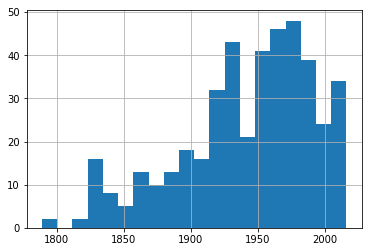

In [137]:
catalog.year.dropna().hist(bins=20)

In [285]:
cos_dist_train = pdist(x_train_sc, metric='cosine')

print("cos train rpec:", np.mean(r_precision_m(matrix=pd.DataFrame(cos_dist_train), authors=y_train)))
print("cos train ndcg:", np.mean(ndcg_m(pd.DataFrame(cos_dist_train), book_ids_train)))

cos train rpec: 0.24790039580648718
cos train ndcg: 0.5199788075534204


In [283]:
np.unique(rel_matrix, return_counts=True), np.count_nonzero(rel_matrix)

((array([0., 1., 2., 3., 4.]),
  array([369976,  19510,  22104,   2502,    644])),
 44760)

In [72]:
def prepare_for_xgb(X, books_ids, M=1, random_state=17):
    np.seed(random_state)
    positive = []
    labels_positive = []
    counter = Counter()
    for i, x1 in enumerate(X):
        for j, x2 in enumerate(X):
            book_id1 = books_ids[i]
            book_id2 = books_ids[j]
            rel = rel_matrix[book_id1][book_id2]
            if counter[rel] > 10000:
                continue
            if rel != 0 and rel !=SAME_AGE and i != j:
                counter[rel] += 1
                positive.append( np.abs(x1 - x2) )
                labels_positive.append(
                    M * (SAME_BOOK - rel)
                )
    print(len(positive), 'positive pairs')
    negative = []
    labels_negative = []
    
    while len(negative) < len(positive) / 2:
        i, j = np.random.choice(books_ids, 2, replace=False)
        book_id1 = books_ids[i]
        book_id2 = books_ids[j]
        if rel_matrix[i][j] != 0:
            continue
        negative.append(
            np.abs(X[i] - X[j])
        )
        labels_negative.append(
            M * SAME_BOOK
        )

    data = np.array([*positive, *negative])
    del positive, negative
    labels = np.array([*labels_positive, *labels_negative])
    del labels_positive, labels_negative
    return data, labels

In [63]:
data_train, labels_train = prepare_for_xgb(x_train_sc, book_ids_train, 100)

19519 positive pairs


In [69]:
data_test, labels_test = prepare_for_xgb(x_test_sc, book_ids_test, 100)

19519 positive pairs


In [75]:
gc.collect()

175

In [73]:
eval_set = [(data_train, labels_train), (data_test, labels_test)]

In [74]:
from xgboost import XGBRegressor, plot_importance

In [76]:
xreg = XGBRegressor(objective ='reg:linear', n_jobs=1, booster='gbtree', 
              n_estimators=2000, subsample=0.8, colsample_by_tree=0.7)

In [77]:
%%time
xreg.fit(data_train,labels_train, eval_set=eval_set, early_stopping_rounds=50)

[0]	validation_0-rmse:270.377	validation_1-rmse:270.449
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:249.442	validation_1-rmse:249.691
[2]	validation_0-rmse:230.986	validation_1-rmse:230.735
[3]	validation_0-rmse:214.758	validation_1-rmse:213.26
[4]	validation_0-rmse:200.602	validation_1-rmse:198.194
[5]	validation_0-rmse:188.274	validation_1-rmse:187.987
[6]	validation_0-rmse:177.6	validation_1-rmse:179.437
[7]	validation_0-rmse:168.359	validation_1-rmse:169.042
[8]	validation_0-rmse:160.407	validation_1-rmse:162.875
[9]	validation_0-rmse:153.6	validation_1-rmse:156.782
[10]	validation_0-rmse:147.749	validation_1-rmse:150.946
[11]	validation_0-rmse:142.733	validation_1-rmse:146.236
[12]	validation_0-rmse:138.493	validation_1-rmse:143.053
[13]	validation_0-rmse:134.896	validation_1-rmse:138.26
[14]	validation_0-rmse:131.798	validation_1-rmse:135.147
[1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_by_tree=0.7,
       colsample_bylevel=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [78]:
del data_train, data_test, labels_test, labels_train, eval_set
gc.collect()

2039

In [79]:
%%time
dist_xgb_train = np.zeros((len(x_train_sc), len(x_train_sc)))
for i, x1 in enumerate(x_train_sc):
    for j, x2 in enumerate(x_train_sc):
        if dist_xgb_train[i][j] == 0:
            p = xreg.predict(np.abs([x1 - x2]))[0]
            dist_xgb_train[i][j] = p
            dist_xgb_train[j][i] = p

print("xgb train rpec:", np.mean(r_precision_m(matrix=pd.DataFrame(dist_xgb_train), authors=y_train)))
print("xgb train ndcg:", np.mean(ndcg_m(pd.DataFrame(dist_xgb_train), book_ids_train)))

dist_xgb_test = np.zeros((len(x_test_sc), len(x_test_sc)))
for i, x1 in enumerate(x_test_sc):
    for j, x2 in enumerate(x_test_sc):
        if dist_xgb_test[i][j] == 0:
            p = xreg.predict(np.abs([x1 - x2]))[0]
            dist_xgb_test[i][j] = p
            dist_xgb_test[j][i] = p

print("xgb test rpec:", np.mean(r_precision_m(matrix=pd.DataFrame(dist_xgb_test), authors=y_test)))
print("xgb test ndcg:", np.mean(ndcg_m(pd.DataFrame(dist_xgb_test), book_ids_test)))


xgb train rpec: 0.17195992224545523
xgb train ndcg: 0.4100445469465443
xgb test rpec: 0.03834686769331439
xgb train ndcg: 0.16485617083912527
CPU times: user 27min 9s, sys: 132 ms, total: 27min 9s
Wall time: 27min 9s


In [85]:
dist_xgb_test.mean(), dist_xgb_test.std(), dist_xgb_test.min(), dist_xgb_test.max()

(271.73884129001294, 28.113553989342968, 135.90333557128906, 360.4917297363281)

In [111]:
xreg.feature_importances_.argsort()[::-1][:30]

array([   6,   17,    4,   22,   20,   11,   24,  112,   23,   14, 2597,
       3163,   35,  162,  913,    1,   21,   12, 3156, 3608, 3604, 3224,
        261, 2761, 3497, 2240, 1906,    0, 2289,  168])

array(['type_token', 's conj v', 'fraction_CONJ', 'pвнутр pтире conj',
       'fraction_ADV', 'fraction_VДЕЕПР', 'fraction_APRO', 'avg_snt',
       'rare_word_%', 'a pвнутр a', 'pгран spro v', 'pr s pтире',
       'pгран pтире v', 's pвнутр conj', 'a s pгран', 'pвнутр spro v',
       'pвнутр adv vдеепр', 'pвнутр advpro conj', 'pкавычки s pкавычки',
       's pтире s', 'v pвнутр nl', 's pтире conj', 'a conj a',
       'adv adv vдеепр', 'pr apro apro', 'spro v s', 's pкавычки s',
       'pтире adv v', 'pr s conj', 's pвнутр pтире', 'fraction_PR',
       's pвнутр nl', 'dialog_%', 'pr s pгран', 'nl spro v'], dtype='<U24')

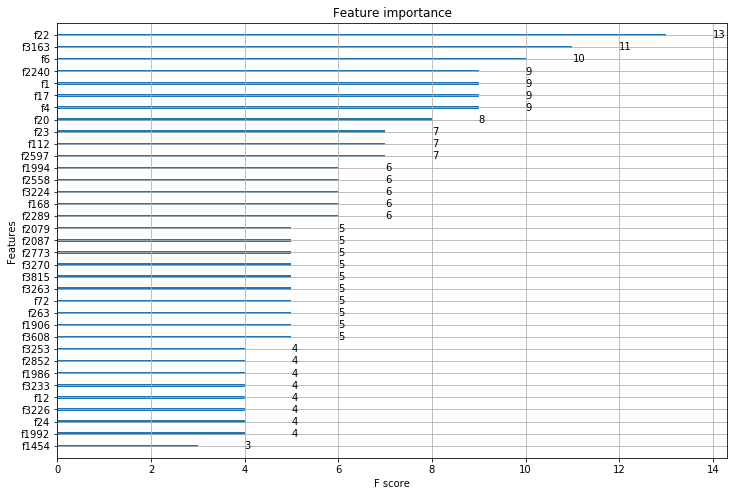

In [184]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
t = plot_importance(xreg, max_num_features=35, ax=ax)
np.array(feature_names)[np.array([int(w.get_text()[1:]) for w in t.get_yticklabels()[::-1]])]

In [186]:
dic = {}
dists = pd.DataFrame(dist_xgb_test)
for i in dists:
    col = dists[i]
    closest = idx_test[col.argsort()[:15]]
    arr = [(get_author_name(book_fbusta_ids[x], catalog), get_book_name(book_fbusta_ids[x], catalog)) for x in closest]
    dic[arr[0]] = arr[1:]
from pprint import pprint
stream = open('xgb_xgb_5000pos_readability_chunks15_stratified', 'w')
pprint(dic, stream)

In [187]:
xreg.save_model('xgb5000_25_ch15_strat')

In [189]:
np.savetxt('dist_xgb_test.txt', dist_xgb_test)
np.savetxt('dist_xgb_train.txt', dist_xgb_train)

In [ ]:
for author in authors:
    print()
    break

In [214]:
catalog[catalog.author_surname == 'Рубина']

,Unnamed: 0,author_surname,fbusta_id,author_id,author_name,book_id,book_title,polka_title,size,year,wiki_book,wiki_author,author_com_links,book_com_links
490,491,Рубина,173678,111,Дина Ильинична,501,Белая голубка Кордовы,NaN,426,2009.0,https://ru.wikipedia.org/wiki/Белая_голубка_Ко...,"https://ru.wikipedia.org/wiki/Рубина,_Дина_Иль...",58_101_134_59_138_75_108_141_143_17_93_53_118_...,503
491,492,Рубина,202993,111,Дина Ильинична,502,На солнечной стороне улицы,NaN,336,2006.0,NaN,"https://ru.wikipedia.org/wiki/Рубина,_Дина_Иль...",58_101_134_59_138_75_108_141_143_17_93_53_118_...,NaN
492,493,Рубина,100333,111,Дина Ильинична,503,Почерк Леонардо,NaN,311,2008.0,https://ru.wikipedia.org/wiki/Почерк_Леонардо,"https://ru.wikipedia.org/wiki/Рубина,_Дина_Иль...",58_101_134_59_138_75_108_141_143_17_93_53_118_...,501
493,494,Рубина,214746,111,Дина Ильинична,504,Синдром Петрушки,NaN,318,2010.0,NaN,"https://ru.wikipedia.org/wiki/Рубина,_Дина_Иль...",58_101_134_59_138_75_108_141_143_17_93_53_118_...,NaN


In [212]:
book_ids[0]

array([503, 503, 503, ..., 490, 490, 490])

In [220]:
used = set()
for i, bi in enumerate(idx_test):
    for j, bj in enumerate(idx_test):
        if book_ids[bi]==book_ids[bj] or (book_ids[bi], book_ids[bj]) in used or (book_ids[bj], book_ids[bi]) in used:
            continue
        print(i, j, bi, bj, book_ids[bi], book_ids[bj])
        author_i = catalog[catalog['author_id'] == authors[bi]]['author_surname'].iloc[0]
        author_j = catalog[catalog['author_id'] == authors[bj]]['author_surname'].iloc[0]
        print(author_i + book_names[bi], author_j+book_names[bj])
        used.add((book_ids[bi], book_ids[bj]))
        

0 2 365 369 1 4
АбрамовБратья и сестры АбрамовДом
0 4 365 374 1 2
АбрамовБратья и сестры АбрамовДве зимы и три лета
0 5 365 377 1 3
АбрамовБратья и сестры АбрамовПути-перепутья
0 8 365 150 1 8
АбрамовБратья и сестры АкунинАлтын-Толобас
0 11 365 247 1 5
АбрамовБратья и сестры АкунинНефритовые четки
0 12 365 759 1 9
АбрамовБратья и сестры АкунинФ. М.
0 15 365 1194 1 6
АбрамовБратья и сестры АкунинТурецкий гамбит
0 17 365 1790 1 7
АбрамовБратья и сестры АкунинСтатский советник
0 18 365 129 1 11
АбрамовБратья и сестры АлексиевичПоследние свидетели (сто недетских рассказов)
0 20 365 1644 1 13
АбрамовБратья и сестры АлексиевичЧернобыльская молитва. Хроника будущего
0 21 365 1645 1 14
АбрамовБратья и сестры АлексиевичВремя секонд хэнд
0 24 365 1650 1 12
АбрамовБратья и сестры АлексиевичЦинковые мальчики
0 26 365 2119 1 10
АбрамовБратья и сестры АлексиевичУ войны - не женское лицо…
0 28 365 40 1 16
АбрамовБратья и сестры АлексинМой брат играет на кларнете
0 29 365 48 1 17
АбрамовБратья и сестр

АбрамовБратья и сестры ГогольВий
0 395 365 2148 1 220
АбрамовБратья и сестры ГогольВечера на хуторе близ Диканьки
0 396 365 2273 1 212
АбрамовБратья и сестры ГогольНевский проспект
0 398 365 2276 1 216
АбрамовБратья и сестры ГогольНос
0 400 365 2279 1 217
АбрамовБратья и сестры ГогольПортрет
0 402 365 2283 1 221
АбрамовБратья и сестры ГогольЗаписки сумасшедшего
0 403 365 572 1 226
АбрамовБратья и сестры ГончаровОбыкновенная история
0 405 365 781 1 223
АбрамовБратья и сестры ГончаровИван Савич Поджабрин
0 408 365 786 1 224
АбрамовБратья и сестры ГончаровМильон терзаний
0 410 365 1872 1 222
АбрамовБратья и сестры ГончаровОбломов
0 412 365 2141 1 225
АбрамовБратья и сестры ГончаровОбрыв
0 413 365 791 1 228
АбрамовБратья и сестры ГорькийМать
0 415 365 793 1 230
АбрамовБратья и сестры ГорькийМои университеты
0 417 365 896 1 227
АбрамовБратья и сестры ГорькийДело Артамоновых
0 419 365 294 1 231
АбрамовБратья и сестры ГранинЕще заметен след
0 420 365 837 1 234
АбрамовБратья и сестры ГранинКар

АбрамовБратья и сестры ПоповПлясать до смерти
0 830 365 173 1 452
АбрамовБратья и сестры ПрилепинБотинки, полные горячей водки
0 833 365 237 1 453
АбрамовБратья и сестры ПрилепинГрех
0 835 365 939 1 455
АбрамовБратья и сестры ПрилепинПатологии
0 837 365 944 1 456
АбрамовБратья и сестры ПрилепинСанькя
0 838 365 1410 1 454
АбрамовБратья и сестры ПрилепинОбитель
0 840 365 652 1 457
АбрамовБратья и сестры ПришвинКащеева цепь
0 841 365 1521 1 460
АбрамовБратья и сестры ПришвинТом 6. Осударева дорога. Корабельная чаща
0 843 365 1524 1 459
АбрамовБратья и сестры ПришвинТом 3. Журавлиная родина. Календарь природы
0 846 365 2291 1 458
АбрамовБратья и сестры ПришвинКоролева бобров
0 848 365 920 1 463
АбрамовБратья и сестры ПриставкинНочевала тучка золотая
0 849 365 1587 1 462
АбрамовБратья и сестры ПриставкинКукушата, или Жалобная песнь для успокоения сердца
0 851 365 1737 1 461
АбрамовБратья и сестры ПриставкинГородок
0 853 365 2189 1 464
АбрамовБратья и сестры ПриставкинСолдат и мальчик
0 856 

0 1169 365 639 1 643
АбрамовБратья и сестры ЗамятинРассказ о самом главном
0 1171 365 643 1 641
АбрамовБратья и сестры ЗамятинМы
0 1173 365 649 1 639
АбрамовБратья и сестры ЗамятинЛовец человеков
0 1174 365 56 1 646
АбрамовБратья и сестры ЗощенкоПовесть о разуме
0 1176 365 275 1 644
АбрамовБратья и сестры ЗощенкоГолубая книга
0 1177 365 1104 1 645
АбрамовБратья и сестры ЗощенкоЛёля и Минька
0 1180 365 2017 1 647
АбрамовБратья и сестры ЗощенкоВозвращенная молодость
2 4 369 374 4 2
АбрамовДом АбрамовДве зимы и три лета
2 5 369 377 4 3
АбрамовДом АбрамовПути-перепутья
2 8 369 150 4 8
АбрамовДом АкунинАлтын-Толобас
2 11 369 247 4 5
АбрамовДом АкунинНефритовые четки
2 12 369 759 4 9
АбрамовДом АкунинФ. М.
2 15 369 1194 4 6
АбрамовДом АкунинТурецкий гамбит
2 17 369 1790 4 7
АбрамовДом АкунинСтатский советник
2 18 369 129 4 11
АбрамовДом АлексиевичПоследние свидетели (сто недетских рассказов)
2 20 369 1644 4 13
АбрамовДом АлексиевичЧернобыльская молитва. Хроника будущего
2 21 369 1645 4 14
Аб

АбрамовДом ГранинИду на грозу
2 429 369 334 4 236
АбрамовДом ГринАлые паруса
2 432 369 486 4 240
АбрамовДом ГринЗолотая цепь
2 434 369 1332 4 239
АбрамовДом ГринСокровище африканских гор
2 437 369 1338 4 238
АбрамовДом ГринНедотрога
2 438 369 2157 4 237
АбрамовДом ГринБлистающий мир
2 439 369 680 4 242
АбрамовДом ГришковецАсфальт
2 441 369 682 4 243
АбрамовДом ГришковецРеки
2 444 369 718 4 244
АбрамовДом ГришковецРубашка
2 446 369 738 4 241
АбрамовДом ГришковецА.....а
2 447 369 841 4 245
АбрамовДом ГроссманЧетыре дня
2 450 369 845 4 246
АбрамовДом ГроссманДобро вам!
2 453 369 1270 4 247
АбрамовДом ГроссманГоды войны
2 455 369 1421 4 249
АбрамовДом ГроссманЗа правое дело
2 457 369 2151 4 248
АбрамовДом ГроссманВсе течёт
2 459 369 342 4 254
АбрамовДом ХармсСтаруха
2 460 369 2266 4 253
АбрамовДом ХармсСлучаи
2 462 369 354 4 256
АбрамовДом ИскандерМорской скорпион
2 463 369 361 4 258
АбрамовДом ИскандерСозвездие Козлотура
2 465 369 1090 4 257
АбрамовДом ИскандерСандро из Чегема
2 467 369 1

АбрамовДом ПриставкинСолдат и мальчик
2 856 369 706 4 468
АбрамовДом ПрохановМесто действия
2 858 369 927 4 469
АбрамовДом ПрохановШестьсот лет после битвы
2 860 369 1303 4 470
АбрамовДом ПрохановВремя золотое
2 863 369 1728 4 465
АбрамовДом ПрохановЧеченский блюз
2 864 369 1734 4 466
АбрамовДом ПрохановГосподин Гексоген
2 866 369 2185 4 467
АбрамовДом ПрохановИдущие в ночи
2 868 369 655 4 473
АбрамовДом ПрокофьеваПока бьют часы
2 871 369 669 4 474
АбрамовДом ПрокофьеваПриключения жёлтого чемоданчика
2 872 369 670 4 476
АбрамовДом ПрокофьеваУченик волшебника
2 875 369 674 4 472
АбрамовДом ПрокофьеваОстров капитанов
2 878 369 1774 4 475
АбрамовДом ПрокофьеваСказка о ветре в безветренный день
2 880 369 583 4 484
АбрамовДом ПушкинПовести Белкина
2 882 369 1015 4 479
АбрамовДом ПушкинДубровский
2 884 369 2183 4 483
АбрамовДом ПушкинПиковая Дама
2 886 369 318 4 487
АбрамовДом РадищевПутешествие из Петербурга в Москву
2 888 369 315 4 492
АбрамовДом РаспутинЖиви и помни
2 890 369 1292 4 488
А

KeyboardInterrupt: 

### 3pos + LSML

In [41]:
prior = np.ones((len(x_train_sc), len(x_train_sc)))
for i, a1 in enumerate(y_train):
    for j, a2 in enumerate(y_train):
        if a1 == a2:
            prior[i][j] = 0
            prior[j][i] = 0

In [42]:
clf = LSML_Supervised(num_constraints=300, verbose=True, prior=prior)

In [43]:
%%time
clf.fit(x_train_sc, y_train)

LinAlgError: Singular matrix

In [437]:
y_train[460]

56

In [429]:
from metric_learn import Constraints
c = Constraints.random_subset(y_train, np.inf, random_state=np.random)
c.positive_negative_pairs(10)

(array([280, 479, 365, 293, 272, 472, 312,  76, 109, 458]),
 array([ 41,  43,  44, 292, 167, 473, 313, 485, 136, 489]),
 array([ 54,  12, 405, 376, 465, 244, 462, 285, 430, 125]),
 array([365, 460,  35,  99, 145, 329, 366, 302, 232, 251]))

In [134]:
idx_train, idx_test = train_test_split(X, authors, return_idx=True, mod='s')
x_train, y_train, x_test, y_test = X[idx_train], authors[idx_train], X[idx_test], authors[idx_test]
book_ids_train, book_ids_test = book_ids[idx_train], book_ids[idx_test]

test_fraction: 0.5051194539249146


In [135]:
scaler = StandardScaler().fit(x_train)
x_train_sc = scaler.transform(x_train)
x_test_sc = scaler.transform(x_test)

In [136]:
%%time
eu_train_matrix = pdist(x_train_sc)
eu_test_matrix = pdist(x_test_sc)
print("eu train rpec:", np.mean(r_precision_m(matrix=pd.DataFrame(eu_train_matrix), authors=y_train)))
print("eu test rpec:", np.mean(r_precision_m(matrix=pd.DataFrame(eu_test_matrix), authors=y_test)))

eu train rpec: 0.1593026260995011
eu test rpec: 0.1761742375023625
CPU times: user 6.9 s, sys: 7.96 ms, total: 6.91 s
Wall time: 6.91 s


In [137]:
%%time
sk_cov_metric = DistanceMetric.get_metric('mahalanobis', V=np.cov(x_train_sc.T))

CPU times: user 2.85 ms, sys: 13 µs, total: 2.86 ms
Wall time: 1.71 ms


In [138]:
%%time
distances = sk_cov_metric.pairwise(x_train_sc)

CPU times: user 422 ms, sys: 5 µs, total: 422 ms
Wall time: 418 ms


In [139]:
np.array(r_precision_m(authors=y_train, matrix=pd.DataFrame(distances))).mean()

0.007913934085809086

In [140]:
test_dist =  sk_cov_metric.pairwise(x_test_sc)
np.array(r_precision_m(authors=y_test, matrix=pd.DataFrame(test_dist))).mean()

0.008463307291432293

In [141]:
np.isnan(distances).sum(), np.isnan(test_dist).sum()

(199160, 197736)

In [142]:
np.linalg.det(np.cov(x_train_sc.T))

-2.999238996186679e-22

### удобочитаемые + xgb

In [143]:
X = np.c_[pos_fractions.toarray(), avg_sent_l, avg_len_word, type_token_ratio, rwf, dia_frac]

idx_train, idx_test = train_test_split(X, authors, return_idx=True, mod='s')
x_train, y_train, x_test, y_test = X[idx_train], authors[idx_train], X[idx_test], authors[idx_test]
book_ids_train, book_ids_test = book_ids[idx_train], book_ids[idx_test]

scaler = StandardScaler().fit(x_train)
x_train_sc = scaler.transform(x_train)
x_test_sc = scaler.transform(x_test)

test_fraction: 0.5051194539249146


In [144]:
np.random.seed(17)
CLOSE = 0
MID = 1
FAR = 2
positive = []
labels_positive = []
for i, x1 in enumerate(x_train_sc):
    for j, x2 in enumerate(x_train_sc):
        if book_ids_train[i] == book_ids_train[j] and i != j:
            positive.append(
                np.abs(x1 - x2)
            )
            labels_positive.append(CLOSE)
        elif y_train[i] == y_train[j] and i != j:
            positive.append(
                np.abs(x1 - x2)
            )
            labels_positive.append(MID)

negative = []
labels_negative = []
while len(negative) < len(positive):
    idx1, idx2 = np.random.choice(len(y_train), 2, replace=False)
    if y_train[idx1] == y_train[idx2]:
        continue
    negative.append(
        np.abs(x_train_sc[idx1] - x_train_sc[idx2])
    )
    labels_negative.append(FAR)

data_train = [*positive, *negative]
labels_train = [*labels_positive, *labels_negative]

positive_test = []
labels_positive_test = []
for i, x1 in enumerate(x_test_sc):
    for j, x2 in enumerate(x_test_sc):
        if book_ids_test[i] == book_ids_test[j] and i != j:
            positive_test.append(
                np.abs(x1 - x2)
            )
            labels_positive_test.append(CLOSE)
        elif y_test[i] == y_test[j] and i != j:
            positive_test.append(
                np.abs(x1 - x2)
            )
            labels_positive_test.append(MID)
            
negative_test = []
labels_negative_test = []
while len(negative_test) < len(positive_test):
    idx1, idx2 = np.random.choice(len(y_test), 2, replace=False)
    if y_test[idx1] == y_test[idx2]:
        continue
    negative_test.append(
        np.abs(x_test_sc[idx1] - x_test_sc[idx2])
    )
    labels_negative_test.append(FAR)
    
data_test = [*positive_test, *negative_test]
labels_test = [*labels_positive_test, *labels_negative_test]

eval_set = [(data_train, labels_train), (data_test, labels_test)]

In [145]:
xreg = XGBRegressor(objective ='reg:linear', n_jobs=1, booster='gbtree', n_estimators=2000, subsample=0.7)

In [146]:
%%time
xreg.fit(data_train,labels_train, eval_set=eval_set, early_stopping_rounds=150)

[0]	validation_0-rmse:1.03787	validation_1-rmse:1.03913
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 150 rounds.
[1]	validation_0-rmse:0.967473	validation_1-rmse:0.969805
[2]	validation_0-rmse:0.906704	validation_1-rmse:0.909675
[3]	validation_0-rmse:0.854092	validation_1-rmse:0.857755
[4]	validation_0-rmse:0.808458	validation_1-rmse:0.812358
[5]	validation_0-rmse:0.768853	validation_1-rmse:0.773029
[6]	validation_0-rmse:0.735234	validation_1-rmse:0.739622
[7]	validation_0-rmse:0.705837	validation_1-rmse:0.710652
[8]	validation_0-rmse:0.680938	validation_1-rmse:0.686302
[9]	validation_0-rmse:0.659411	validation_1-rmse:0.664933
[10]	validation_0-rmse:0.641133	validation_1-rmse:0.647085
[11]	validation_0-rmse:0.625597	validation_1-rmse:0.631876
[12]	validation_0-rmse:0.612426	validation_1-rmse:0.618948
[13]	validation_0-rmse:0.600601	validation_1-rmse:0.607486
[14]	validation_0-rmse:0.5

[137]	validation_0-rmse:0.488239	validation_1-rmse:0.526311
[138]	validation_0-rmse:0.487995	validation_1-rmse:0.526315
[139]	validation_0-rmse:0.487572	validation_1-rmse:0.526084
[140]	validation_0-rmse:0.487242	validation_1-rmse:0.525878
[141]	validation_0-rmse:0.487033	validation_1-rmse:0.525905
[142]	validation_0-rmse:0.486443	validation_1-rmse:0.525538
[143]	validation_0-rmse:0.486232	validation_1-rmse:0.525594
[144]	validation_0-rmse:0.486005	validation_1-rmse:0.525656
[145]	validation_0-rmse:0.485725	validation_1-rmse:0.525615
[146]	validation_0-rmse:0.485453	validation_1-rmse:0.525629
[147]	validation_0-rmse:0.485237	validation_1-rmse:0.52559
[148]	validation_0-rmse:0.485069	validation_1-rmse:0.525502
[149]	validation_0-rmse:0.484738	validation_1-rmse:0.525315
[150]	validation_0-rmse:0.484479	validation_1-rmse:0.525165
[151]	validation_0-rmse:0.484259	validation_1-rmse:0.525138
[152]	validation_0-rmse:0.484046	validation_1-rmse:0.525013
[153]	validation_0-rmse:0.483809	validati

[275]	validation_0-rmse:0.460155	validation_1-rmse:0.522508
[276]	validation_0-rmse:0.459926	validation_1-rmse:0.522422
[277]	validation_0-rmse:0.459748	validation_1-rmse:0.522451
[278]	validation_0-rmse:0.459646	validation_1-rmse:0.522438
[279]	validation_0-rmse:0.459497	validation_1-rmse:0.522445
[280]	validation_0-rmse:0.459321	validation_1-rmse:0.522473
[281]	validation_0-rmse:0.459102	validation_1-rmse:0.522433
[282]	validation_0-rmse:0.458926	validation_1-rmse:0.522489
[283]	validation_0-rmse:0.458833	validation_1-rmse:0.522507
[284]	validation_0-rmse:0.458669	validation_1-rmse:0.522511
[285]	validation_0-rmse:0.458451	validation_1-rmse:0.522553
[286]	validation_0-rmse:0.458266	validation_1-rmse:0.522514
[287]	validation_0-rmse:0.458046	validation_1-rmse:0.522506
[288]	validation_0-rmse:0.457845	validation_1-rmse:0.522526
[289]	validation_0-rmse:0.457648	validation_1-rmse:0.522569
[290]	validation_0-rmse:0.457502	validation_1-rmse:0.5226
[291]	validation_0-rmse:0.457323	validatio

[413]	validation_0-rmse:0.437935	validation_1-rmse:0.522038
[414]	validation_0-rmse:0.437777	validation_1-rmse:0.522011
[415]	validation_0-rmse:0.437691	validation_1-rmse:0.522031
[416]	validation_0-rmse:0.437538	validation_1-rmse:0.522059
[417]	validation_0-rmse:0.437386	validation_1-rmse:0.522066
[418]	validation_0-rmse:0.437205	validation_1-rmse:0.522047
[419]	validation_0-rmse:0.437081	validation_1-rmse:0.522085
[420]	validation_0-rmse:0.436972	validation_1-rmse:0.522103
[421]	validation_0-rmse:0.436814	validation_1-rmse:0.522041
[422]	validation_0-rmse:0.436679	validation_1-rmse:0.522023
[423]	validation_0-rmse:0.436564	validation_1-rmse:0.522058
[424]	validation_0-rmse:0.43645	validation_1-rmse:0.522083
[425]	validation_0-rmse:0.436265	validation_1-rmse:0.522059
[426]	validation_0-rmse:0.436133	validation_1-rmse:0.522075
[427]	validation_0-rmse:0.435899	validation_1-rmse:0.521989
[428]	validation_0-rmse:0.435764	validation_1-rmse:0.521983
[429]	validation_0-rmse:0.435565	validati

[550]	validation_0-rmse:0.419218	validation_1-rmse:0.523111
[551]	validation_0-rmse:0.419064	validation_1-rmse:0.52313
[552]	validation_0-rmse:0.418939	validation_1-rmse:0.523114
[553]	validation_0-rmse:0.418798	validation_1-rmse:0.523059
[554]	validation_0-rmse:0.41866	validation_1-rmse:0.523026
[555]	validation_0-rmse:0.418563	validation_1-rmse:0.523067
[556]	validation_0-rmse:0.418463	validation_1-rmse:0.523075
[557]	validation_0-rmse:0.418363	validation_1-rmse:0.523064
[558]	validation_0-rmse:0.418248	validation_1-rmse:0.523119
[559]	validation_0-rmse:0.418102	validation_1-rmse:0.523139
[560]	validation_0-rmse:0.417956	validation_1-rmse:0.523105
[561]	validation_0-rmse:0.417844	validation_1-rmse:0.523057
[562]	validation_0-rmse:0.41767	validation_1-rmse:0.52302
[563]	validation_0-rmse:0.417563	validation_1-rmse:0.523035
[564]	validation_0-rmse:0.417391	validation_1-rmse:0.523079
[565]	validation_0-rmse:0.417253	validation_1-rmse:0.523079
[566]	validation_0-rmse:0.417131	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.7)

In [147]:
%%time
dist_xgb_train = np.zeros((len(x_train_sc), len(x_train_sc)))
for i, x1 in enumerate(x_train_sc):
    for j, x2 in enumerate(x_train_sc):
        if dist_xgb_train[i][j] == 0:
            p = xreg.predict(np.abs([x1 - x2]))[0]
            dist_xgb_train[i][j] = p
            dist_xgb_train[j][i] = p

print("xgb train rpec:", np.mean(r_precision_m(matrix=pd.DataFrame(dist_xgb_train), authors=y_train)))

dist_xgb_test = np.zeros((len(x_test_sc), len(x_test_sc)))
for i, x1 in enumerate(x_test_sc):
    for j, x2 in enumerate(x_test_sc):
        if dist_xgb_test[i][j] == 0:
            p = xreg.predict(np.abs([x1 - x2]))[0]
            dist_xgb_test[i][j] = p
            dist_xgb_test[j][i] = p

print("xgb test rpec:", np.mean(r_precision_m(matrix=pd.DataFrame(dist_xgb_test), authors=y_test)))

xgb train rpec: 0.16793269254206755
xgb test rpec: 0.16066119034869034
CPU times: user 2min 31s, sys: 3.91 ms, total: 2min 31s
Wall time: 2min 31s


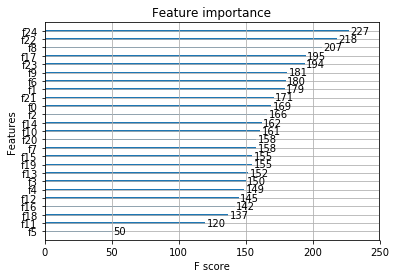

In [148]:
plot_importance(xreg, max_num_features=50)

#### 25 + itml

In [96]:
clf = ITML_Supervised(num_constraints=1000, verbose=True, convergence_threshold=0.001)

In [97]:
x_train_sc.shape

(337, 25)

In [98]:
%%time
clf.fit(x_train_sc, y_train)

/home/artesby/anaconda3/envs/myenv/lib/python3.7/site-packages/metric_learn/constraints.py:62: UserWarning: Only generated 566 positive constraints (requested 1000)
  len(ab), 'positive' if same_label else 'negative', num_constraints))


itml iter: 0, conv = 12.257700
itml iter: 1, conv = 3.591601
itml iter: 2, conv = 2.246185
itml iter: 3, conv = 1.709264
itml iter: 4, conv = 1.423264
itml iter: 5, conv = 1.223823
itml iter: 6, conv = 1.087506
itml iter: 7, conv = 0.983216
itml iter: 8, conv = 0.898864
itml iter: 9, conv = 0.831640
itml iter: 10, conv = 0.774728
itml iter: 11, conv = 0.731870
itml iter: 12, conv = 0.690364
itml iter: 13, conv = 0.656431
itml iter: 14, conv = 0.624659
itml iter: 15, conv = 0.595801
itml iter: 16, conv = 0.572897
itml iter: 17, conv = 0.550198
itml iter: 18, conv = 0.529966
itml iter: 19, conv = 0.511145
itml iter: 20, conv = 0.493404
itml iter: 21, conv = 0.480161
itml iter: 22, conv = 0.469824
itml iter: 23, conv = 0.462531
itml iter: 24, conv = 0.456121
itml iter: 25, conv = 0.451301
itml iter: 26, conv = 0.444087
itml iter: 27, conv = 0.440911
itml iter: 28, conv = 0.438339
itml iter: 29, conv = 0.435649
itml iter: 30, conv = 0.433826
itml iter: 31, conv = 0.432751
itml iter: 32, co

itml iter: 260, conv = 0.057500
itml iter: 261, conv = 0.056316
itml iter: 262, conv = 0.055077
itml iter: 263, conv = 0.053891
itml iter: 264, conv = 0.052867
itml iter: 265, conv = 0.051884
itml iter: 266, conv = 0.050896
itml iter: 267, conv = 0.049953
itml iter: 268, conv = 0.048961
itml iter: 269, conv = 0.048151
itml iter: 270, conv = 0.047548
itml iter: 271, conv = 0.047073
itml iter: 272, conv = 0.046595
itml iter: 273, conv = 0.046000
itml iter: 274, conv = 0.045459
itml iter: 275, conv = 0.044919
itml iter: 276, conv = 0.044331
itml iter: 277, conv = 0.043989
itml iter: 278, conv = 0.043788
itml iter: 279, conv = 0.043609
itml iter: 280, conv = 0.043506
itml iter: 281, conv = 0.043408
itml iter: 282, conv = 0.043499
itml iter: 283, conv = 0.043545
itml iter: 284, conv = 0.043404
itml iter: 285, conv = 0.043229
itml iter: 286, conv = 0.043152
itml iter: 287, conv = 0.042952
itml iter: 288, conv = 0.042789
itml iter: 289, conv = 0.042575
itml iter: 290, conv = 0.042276
itml ite

itml iter: 524, conv = 0.003757
itml iter: 525, conv = 0.003747
itml iter: 526, conv = 0.003736
itml iter: 527, conv = 0.003714
itml iter: 528, conv = 0.003699
itml iter: 529, conv = 0.003682
itml iter: 530, conv = 0.003658
itml iter: 531, conv = 0.003636
itml iter: 532, conv = 0.003614
itml iter: 533, conv = 0.003576
itml iter: 534, conv = 0.003531
itml iter: 535, conv = 0.003479
itml iter: 536, conv = 0.003426
itml iter: 537, conv = 0.003367
itml iter: 538, conv = 0.003309
itml iter: 539, conv = 0.003259
itml iter: 540, conv = 0.003204
itml iter: 541, conv = 0.003141
itml iter: 542, conv = 0.003085
itml iter: 543, conv = 0.003040
itml iter: 544, conv = 0.003005
itml iter: 545, conv = 0.002977
itml iter: 546, conv = 0.002946
itml iter: 547, conv = 0.002914
itml iter: 548, conv = 0.002877
itml iter: 549, conv = 0.002843
itml iter: 550, conv = 0.002819
itml iter: 551, conv = 0.002807
itml iter: 552, conv = 0.002795
itml iter: 553, conv = 0.002780
itml iter: 554, conv = 0.002779
itml ite

ITML_Supervised(A0=None, bounds=None, convergence_threshold=0.001, gamma=1.0,
        max_iter=1000, num_constraints=1000, num_labeled=inf, verbose=True)

In [99]:
i_metric = metric(clf.metric())

In [100]:
%%time
test_dist_matrix = pdist(x_test_sc, metric=i_metric)

print(np.mean(r_precision_m(authors=y_test, matrix=pd.DataFrame(test_dist_matrix))))

0.2101879327398615
CPU times: user 502 ms, sys: 72 µs, total: 502 ms
Wall time: 500 ms


In [101]:
%%time
train_dist_matrix = pdist(x_train_sc, metric=i_metric)

print(np.mean(r_precision_m(authors=y_train, matrix=pd.DataFrame(train_dist_matrix))))

0.24480712166172106
CPU times: user 499 ms, sys: 7.96 ms, total: 507 ms
Wall time: 492 ms


#### 25 + lsml

In [102]:
clf = LSML_Supervised(num_constraints=10, verbose=True)

In [103]:
x_train_sc.shape

(337, 25)

In [104]:
np.linalg.det(np.cov((x_train_sc.T)))

1.4256993436072638e-22

In [105]:
%%time
clf.fit(x_train, y_train)

initial loss 298.527408424312
gradient norm 30.882785630722882
iter 1 cost 4.188748029887815 best step 0.07742636826811278
gradient norm 141771692.65391725
iter 2 cost -31.964475658481945 best step 1.0
gradient norm 85.8631656543225
iter 3 cost -31.964475658481945 best step 6.056439338981824e-07
CPU times: user 112 ms, sys: 4.3 ms, total: 116 ms
Wall time: 33.4 ms


LSML_Supervised(max_iter=1000, num_constraints=10, num_labeled=inf,
        prior=None, tol=0.001, verbose=True, weights=None)

In [106]:
l_metric = metric(clf.metric())

In [107]:
%%time
test_dist_matrix = pdist(x_test, metric=l_metric)

print(np.mean(r_precision_m(authors=y_test, matrix=pd.DataFrame(test_dist_matrix))))

0.09446092977250246
CPU times: user 507 ms, sys: 130 µs, total: 507 ms
Wall time: 506 ms


In [108]:
%%time
train_dist_matrix = pdist(x_train, metric=l_metric)

print(np.mean(r_precision_m(authors=y_train, matrix=pd.DataFrame(train_dist_matrix))))

0.08778437190900099
CPU times: user 507 ms, sys: 4.07 ms, total: 511 ms
Wall time: 503 ms


### Most Frequent Words

In [26]:
dir_name = 'txt_cut'

In [104]:
k = 2000

In [105]:
%%time
data = []
lengths = []
# lengths = Counter()
for filename in sorted(os.listdir(dir_name)):
    fbusta_id = int(filename.split('.')[0])
    if get_author_id(fbusta_id, catalog) in singles:
        continue
    with codecs.open(os.path.join(dir_name, filename), encoding='utf-8') as book:
        content = book.read()
        data.append(content)
        lengths.append(len(re.findall(u"(?u)\\b\\w+\\b", content)))
#         lengths[get_book_id(fbusta_id, catalog)] += len(re.findall(u"(?u)\\b\\w+\\b", content))
# lengths = np.array(list(map(lambda t: lengths[t], book_ids)))

CPU times: user 2.73 s, sys: 60.5 ms, total: 2.79 s
Wall time: 2.88 s


In [106]:
data_train = np.array(data)
len_train = np.array(lengths)
authors_train = authors
train_idx = np.array(range(len(authors)))
test_idx = []

In [52]:
train_idx, test_idx = train_test_split(np.array(data), authors, return_idx=True, mod='s')
book_ids_train, book_ids_test = book_ids[train_idx], book_ids[test_idx]
data_train = np.array(data)[train_idx]
authors_train = authors[train_idx]
len_train = np.array(lengths)[train_idx]

test_fraction: 0.5055603079555175


In [71]:
#for 4pos

data = []
lengths = []
for filename in sorted(os.listdir(dir_in_parsed)):
    book_id = int(filename.split('.')[0])
    if get_author_id(book_id, catalog) in singles:
        continue
    with codecs.open(os.path.join(dir_in_parsed, filename), encoding='utf-8') as book:
        content = book.read()
        data.append(content)
        lengths.append(len(re.findall(u"(?u)\\b\\w+\\b", content)))

train_idx, test_idx = train_test_split(np.array(data), authors, return_idx=True, mod='s')
data_train = np.array(data)[train_idx]
authors_train = authors[train_idx]
len_train = np.array(lengths)[train_idx]

test_fraction: 0.5051194539249146


In [32]:
%%time
tri_grams, cv_tri_grams = count_n_grams(data_train, n=3, stopgrams=stop3grams, max_features=2000) #5700

KeyboardInterrupt: 

In [33]:
tri_grams

NameError: name 'tri_grams' is not defined

In [ ]:
td = pd.DataFrame(cv_tri_grams.transform(data_train).todense())
td.columns = sorted(cv_tri_grams.vocabulary_) 
freqs = td.div(len_train, axis=0)
sclr = StandardScaler().fit(freqs)
freqs_sc = sclr.transform(freqs)
cosine_delta = pd.DataFrame(pdist(freqs_sc, metric='cosine') / k)
b_delta = pd.DataFrame(pdist(freqs_sc, metric='manhattan') / k)
np.mean(r_precision_m(cosine_delta, authors_train)), np.mean(r_precision_m(b_delta, authors_train))

In [479]:
data_test = np.array(data)[test_idx]
authors_test = authors[test_idx]
len_test = np.array(lengths)[test_idx]

In [480]:
td = pd.DataFrame(cv_tri_grams.transform(data_test).todense())
td.columns = sorted(cv_tri_grams.vocabulary_)

freqs_test = td.div(len_test, axis=0)
freqs_test_sc = sclr.transform(freqs_test)
cosine_delta_test = pd.DataFrame(pdist(freqs_test_sc, metric='cosine') / k)
b_delta_test = pd.DataFrame(pdist(freqs_test_sc, metric='manhattan') / k)
np.mean(r_precision_m(cosine_delta_test, authors_test)), np.mean(r_precision_m(b_delta_test, authors_test))

(0.4047972304648863, 0.3852621167161227)

#### delta

In [355]:
lara_mfw = pd.read_csv('mfw.txt', header=None, sep=' ')[0].values[:k]
lara_mfw

array(['и', 'в', 'не', 'на', 'что', 'с', 'я', 'он', 'а', 'как', 'но',
       'его', 'к', 'это', 'она', 'все', 'по', 'у', 'из', 'за', 'так',
       'от', 'ее', 'ты', 'же', 'было', 'о', 'бы', 'меня', 'мне', 'они',
       'только', 'мы', 'то', 'еще', 'когда', 'если', 'был', 'для', 'вы',
       'чтобы', 'уже', 'их', 'до', 'или', 'ему', 'да', 'даже', 'ни',
       'нет', 'вот', 'была', 'себя', 'него', 'сказал', 'может', 'чем',
       'время', 'были', 'со', 'очень', 'ли', 'под', 'там', 'раз', 'тебя',
       'есть', 'ей', 'теперь', 'того', 'быть', 'где', 'будет', 'ничего',
       'потом', 'во', 'этого', 'нас', 'тебе', 'здесь', 'этот', 'себе',
       'тут', 'после', 'сейчас', 'этом', 'просто', 'кто', 'без', 'больше',
       'можно', 'ну', 'через', 'них', 'том', 'вас', 'при', 'тоже', 'один',
       'надо'], dtype=object)

In [107]:
%%time
cv_mfw = CountVectorizer(max_features=k, token_pattern=u"(?u)\\b\\w+\\b").fit(data_train)
td = pd.DataFrame(cv_mfw.transform(data_train).todense())
td.columns = sorted(cv_mfw.vocabulary_)

CPU times: user 10.7 s, sys: 51.4 ms, total: 10.7 s
Wall time: 10.1 s


In [35]:
whole = ['_'.join([
    get_author_name(book_fbusta_ids[i], catalog),
    get_book_name(book_fbusta_ids[i], catalog)
]) for i in np.concatenate([train_idx, test_idx])]

ridero_df = pd.read_csv('ridero_catalog', sep=';', header=None, index_col=0)
for name in sorted(os.listdir('ridero_books')):
    if name not in ridero_df.index:
        print(name)
    fullname = re.sub('\xa0', ' ', str(ridero_df.loc[name][1]) + '_' + ridero_df.loc[name][2])
    whole.append(fullname)

NameError: name 'train_idx' is not defined

In [108]:
freqs = td.div(len_train, axis=0)
sclr = StandardScaler().fit(freqs)
freqs_sc = sclr.transform(freqs)
cosine_delta = pd.DataFrame(pdist(freqs_sc, metric='cosine'))
b_delta = pd.DataFrame(pdist(freqs_sc, metric='manhattan'))

In [109]:
np.mean(r_precision_m(cosine_delta, authors_train)), np.mean(r_precision_m(b_delta, authors_train))

(0.5338068181818183, 0.36732761286332716)

In [57]:
data_test = np.array(data)[test_idx]
authors_test = authors[test_idx]
len_test = np.array(lengths)[test_idx]

In [58]:
td = pd.DataFrame(cv_mfw.transform(data_test).todense())
td.columns = sorted(cv_mfw.vocabulary_)
freqs_test = td.div(len_test, axis=0)
freqs_test_sc = sclr.transform(freqs_test)
cosine_delta_test = pd.DataFrame(pdist(freqs_test_sc, metric='cosine'))
b_delta_test = pd.DataFrame(pdist(freqs_test_sc, metric='manhattan'))

In [59]:
np.mean(r_precision_m(cosine_delta_test, authors_test)), np.mean(r_precision_m(b_delta_test, authors_test))

(0.3174633835801348, 0.17757436443984667)

In [13]:
#ridero delta

ridero_data = []
ridero_lengths = []
ridero_names = []
for filename in sorted(os.listdir('ridero_books')):
    if not os.path.isfile(os.path.join('ridero_books', filename)):
        continue
    with codecs.open(os.path.join('ridero_books', filename), encoding='utf-8') as book:
        content = book.read()
        ridero_names.append(filename.replace('_', ' ') + '_')
        ridero_data.append(content)
        ridero_lengths.append(len(re.findall(u"(?u)\\b\\w+\\b", content)))

In [137]:
rtd = pd.DataFrame(cv_mfw.transform(ridero_data).todense())
rtd.columns = sorted(cv_mfw.vocabulary_)
freqs_ridero = rtd.div(ridero_lengths, axis=0)
freqs_ridero_sc = sclr.transform(freqs_ridero)

In [156]:
import scipy

In [159]:
dop = []
for i in range(10):
    for j,v in enumerate(freqs_sc):
        dop.append((ridero_names[i], whole[j], 1 - scipy.spatial.distance.cosine(freqs_sc[j], freqs_ridero_sc[i]), 'undirected'))

In [164]:
df = pd.DataFrame(dop)
df.columns = ["Source","Target","Weight","Type"]
df.to_csv('dop.csv', index=False, sep=';')

In [62]:
cosine_delta_whole = pd.DataFrame(pdist(np.concatenate((freqs_sc, freqs_test_sc, freqs_ridero_sc)), metric='cosine'))

In [205]:
dic = {}
for i in cosine_delta_whole:
    col = cosine_delta_whole[i]
    closest = col.argsort()[:11].values
    arr = [(whole[j], j, round(col[j], 3)) for j in closest]
    dic[(arr[0])] = arr[1:]
from pprint import pprint
stream = open('./results/cosine_delta_similarity_whole_2kMFW', 'w')
pprint(dic, stream, width=120)

In [194]:
pprint(dic, width=150)

{('AMBER_The flower by the road', 2781): ['Пенелопа Лайфхард_Мой мучитель',
                                          'К. Граф_Мистер Невыносимость',
                                          'Sussie Little_Жюстин Леметр',
                                          'Светлана Игоревна Яковлева_Город Мёртвых',
                                          'Кристина Новосельцева_37 ночей',
                                          'Натали Бизанс_Исповедь',
                                          'Ана Мелия_Стучитесь, открыто',
                                          'Лина Личман_Живой мертвец, или От судьбы не уйдёшь',
                                          'Александр Волков_Когда темнота заберёт нас',
                                          'Konstantin Kerby_Принцип без принципа'],
 ('Aelita Kowarska_Четвёртая чакра зелёного цвета', 2416): ['Татьяна Ивановна Брицун_Ловушка для самовлюблённых ослов',
                                                            'Екатерина Полухина_Боги 

 ('Анна Дмитриева_Бесконечность в нас. Стихия воды', 2391): ['Анна Сергеевна Платунова_Лесной царь',
                                                             'Светлана Фетисова_Зеленое платье Надежды',
                                                             'Дмитрий Комогоров_Мелодия жизни',
                                                             'Марианна Дубровская_Севернее Рая',
                                                             'Наталья Захарова_Вопросы мастеру',
                                                             'Татьяна Володина_Зверь в тебе',
                                                             'Kate Lans_Сейчас 23',
                                                             'Лена Терехова_Из жизни женщины…',
                                                             'Ирина Насонова_Простой курортный роман',
                                                             'Фируза Акопян_Через времена'],
 ('Анна Кот и ещё 1 автор_Чёрные п

                                            'Платонов_Город Градов',
                                            'Хамархан Хамтай Александр_Воспоминания старого шамана. Молодое поколение',
                                            'Алешковский_Кенгуру',
                                            'Васильев_Встречный бой'],
 ('Васильев_В списках не значился', 1122): ['Васильев_В списках не значился',
                                            'Васильев_В списках не значился',
                                            'Васильев_В списках не значился',
                                            'Хамархан Хамтай Александр_Воспоминания старого шамана. Молодое поколение',
                                            'Домбровский_Рождение мыши',
                                            'Васильев_Встречный бой',
                                            'Гроссман_Четыре дня',
                                            'Некрасов_В родном городе',
                                     

                                  'Гладков_Вольница',
                                  'Гладков_Лихая година',
                                  'Гладков_Вольница',
                                  'Гладков_Вольница',
                                  'Гладков_Вольница',
                                  'Паратиков Павел_Шаг на пути к небу',
                                  'Решетников_Подлиповцы',
                                  'Можаев_Живой'],
 ('Гладков_Маша из Заполья', 386): ['Гладков_Маша из Заполья',
                                    'Гладков_Маша из Заполья',
                                    'Гладков_Маша из Заполья',
                                    'Лесков_Очарованный странник',
                                    'Лесков_Очарованный странник',
                                    'Белов_Привычное дело',
                                    'Фурманов_Чапаев',
                                    'Руслан Нариманович Абубакиров_Родня. Пересохшее русло',
             

                                                       'Надежда Мунцева_Любовь в большом городе',
                                                       'Дмитрий Шабанов и ещё 16 авторов_Негасимый свет',
                                                       'Елена Збаражская_Послезавтра была любовь',
                                                       'Вячеслав Алексейчиков_Тайны одинокого сердца',
                                                       'Ekaterina Lotus_Возмездие Высших Сил',
                                                       'Тамара Гильфанова_Возвращайся к мечтам',
                                                       'Антон Антонович Маштак_Хахаряшки'],
 ('Елена Геллер_Те, кто должен ответить', 2778): ['Дмитрий Волошин_Образованец в большом городе',
                                                  'Анна Май_Новая жизнь',
                                                  'Пелевин_iPhuck 10',
                                                  'Валерий Железнов

 ('Крюков_В глубине', 558): ['Короленко_Судный день',
                             'Маканин_Асан',
                             'Короленко_Судный день',
                             'Сергей Шангин_Без царя в голове',
                             'Шишкин_Взятие Измаила',
                             'Достоевский_Записки из подполья',
                             'Андрей Звонков_Невидимка',
                             'Акунин_Статский советник',
                             'Быков_Мертвым не больно',
                             'Быков_Мертвым не больно'],
 ('Крюков_В глубине', 1734): ['Крюков_Новым строем',
                              'Крюков_Шквал',
                              'Тургенев_Дым',
                              'Крюков_На Тихом Дону',
                              'Мамин-Сибиряк_Хлеб',
                              'Сергей Кулябин_Хроники Эрилхейма',
                              'Крюков_В глубине',
                              'Лесков_Левша',
                         

 ('Набоков_Дар', 1830): ['Петров_Одноэтажная Америка',
                         'Мандельштам_Шум времени',
                         'Носов_Незнайка на Луне',
                         'Славникова_Бессмертный',
                         'Набоков_Дар',
                         'Пастернак_Охранная грамота',
                         'Владимир Циканов_Господа офицеры',
                         'Рубина_Синдром Петрушки',
                         'Набоков_Дар',
                         'Гай Ханов_Моя энциклопедия искусства'],
 ('Набоков_Дар', 1831): ['Набоков_Другие берега',
                         'Набоков_Другие берега',
                         'Ксения Блажиевская_Пробуждение',
                         'Искандер_Созвездие Козлотура',
                         'Салтыков-Щедрин_Пошехонская старина',
                         'Крюков_В глубине',
                         'Славникова_Один в зеркале',
                         'Айтматов_Плаха',
                         'Матвеева_Небеса',
           

                                   'Пьецух_В предчувствии октября',
                                   'Пьецух_В предчувствии октября'],
 ('Петрушевская_Свой круг', 756): ['Людмила Петровна Ржевская_Княгиня',
                                   'Петрушевская_Свой круг',
                                   'Алла Лагутина_Московские джунгли',
                                   'Петрушевская_Время ночь',
                                   'Дана Гельдэ_И малое станет большим, и большое — малым',
                                   'Мара Дорст_Любовь по-немецки',
                                   'Петрушевская_Свой круг',
                                   'Набоков_Лолита',
                                   'Ольга Щекотинская_Как избавиться от синдрома ММ',
                                   'Вагинов_Гарпагониана'],
 ('Петрушевская_Свой круг', 1939): ['Петрушевская_Свой круг',
                                    'Петрушевская_Время ночь',
                                    'Наталья Анатолье

 ('Проханов_Чеченский блюз', 859): ['Астафьев_Пастух и пастушка',
                                    'Проханов_Чеченский блюз',
                                    'Проханов_Идущие в ночи',
                                    'Проханов_Идущие в ночи',
                                    'Валерий Костюк_Этюды по памяти',
                                    'Проханов_Чеченский блюз',
                                    'Проханов_Господин Гексоген',
                                    'Астафьев_Пастух и пастушка',
                                    'Проханов_Господин Гексоген',
                                    'Проханов_Место действия'],
 ('Проханов_Чеченский блюз', 868): ['Проханов_Чеченский блюз',
                                    'Проханов_Идущие в ночи',
                                    'Проханов_Чеченский блюз',
                                    'Проханов_Шестьсот лет после битвы',
                                    'Проханов_Идущие в ночи',
                             

                              'Чарская_Записки маленькой гимназистки'],
 ('Сорокин_Теллурия', 1027): ['Петров_Одноэтажная Америка',
                              'Бек Саха́ров_Время Солнца',
                              'Сорокин_Норма',
                              'Славникова_2017',
                              'Ефремов_Час Быка',
                              'Сергей Кулябин_Хроники Эрилхейма',
                              'Сорокин_Голубое сало',
                              'Эренбург_Что человеку надо',
                              'Симона Балли_Жизнь оправдывает жизнь',
                              'Вагинов_Бамбочада'],
 ('Сорокин_Теллурия', 2204): ['Веллер_О Дикий Запад!',
                              'Людмила Ржевская_Азэми — цветок чертополоха',
                              'Веллер_Жестокий',
                              'Эндрю Огнёфф_Хроники Древних Малефистериум',
                              'Веллер_Бомж',
                              'Сорокин_Теллурия',
         

                                     'Чернышевский_Пролог',
                                     'Чернышевский_Пролог',
                                     'Чернышевский_Пролог',
                                     'Чернышевский_Что делать?',
                                     'Гаршин_Надежда Николаевна',
                                     'Мамин-Сибиряк_Приваловские миллионы',
                                     'Куприн_Впотьмах',
                                     'Тургенев_Дворянское гнездо',
                                     'Куприн_Впотьмах'],
 ('Чернышевский_Что делать?', 228): ['Чернышевский_Что делать?',
                                     'Чернышевский_Что делать?',
                                     'Тургенев_Дворянское гнездо',
                                     'Чернышевский_Пролог',
                                     'Толстой_Хаджи-Мурат',
                                     'Геласимов_Жанна',
                                     'Чернышевский_Пролог',


In [40]:
book_names[test_idx[3]]

'Дом'

In [191]:
dic[('Юрий Подопригора_Я знаю, как тебе помочь!', 2836)]

['Анна Май_Новая жизнь',
 'Дмитрий Волошин_Образованец в большом городе',
 'Оксана Козека_Призрачное счастье',
 'Кристина Новосельцева-Рено_Продавец минут',
 'Ева Онегина_Блондинки предпочитают джентльменов',
 'Гарин-Михайловский_Инженеры',
 'Марья Полётова_Поколение выродков',
 'Светлана Желейкина_Академия обладателей дара',
 'Анна Романова_Последствия',
 'Ольга Алейникова_Девочка со скрипкой']

In [162]:
get_author_name(book_fbusta_ids[test_idx[3]], catalog), get_book_name(book_fbusta_ids[test_idx[3]], catalog)

('Абрамов', 'Дом')

In [125]:
cosine_delta[2].argsort()[:15]

0       2
1     540
2      45
3     269
4     142
5     231
6     103
7     539
8     592
9     572
10    469
11    519
12    100
13    104
14    111
Name: 2, dtype: int64

In [127]:
cosine_delta[2].map(lambda x: 1-x).sort_values(ascending=False).index[:5]
[(get_author_name(book_fbusta_ids[x], catalog), get_book_name(book_fbusta_ids[x], catalog)) for x in cosine_delta[2].map(lambda x: 1-x).sort_values(ascending=False).index[:5]]

[('Булгаков', 'Собачье сердце'),
 ('Айтматов', 'Плаха'),
 ('Домбровский', 'Державин'),
 ('Маканин', 'Испуг'),
 ('Герцен', 'Былое и думы')]

In [128]:
[(get_author_name(book_fbusta_ids[x], catalog), get_book_name(book_fbusta_ids[x], catalog)) for x in train_idx[cosine_delta[2].argsort()[:40]]]

[('Булгаков', 'Собачье сердце'),
 ('Айтматов', 'Плаха'),
 ('Домбровский', 'Державин'),
 ('Маканин', 'Испуг'),
 ('Герцен', 'Былое и думы'),
 ('Короленко', 'В дурном обществе'),
 ('Ерофеев', 'Записки психопата'),
 ('Вагинов', 'Чертогон'),
 ('Славникова', 'Стрекоза, увеличенная до размеров собаки'),
 ('Набоков', 'Машенька'),
 ('Прокофьева', 'Сказка о ветре в безветренный день'),
 ('Соколов', 'Между собакой и волком'),
 ('Абрамов', 'Две зимы и три лета'),
 ('Ерофеев', 'Жизнь с идиотом'),
 ('Пильняк', 'Заволочье'),
 ('Айтматов', 'Белый пароход'),
 ('Можаев', 'Полтора квадратных метра'),
 ('Прокофьева', 'Пока бьют часы'),
 ('Бондарев', 'Последние залпы'),
 ('Нагибин', 'Моя золотая теща'),
 ('Кабаков', 'Последний герой'),
 ('Прокофьева', 'Босая принцесса'),
 ('Улицкая', 'Зеленый шатер'),
 ('Помяловский', 'Данилушка'),
 ('Можаев', 'Мужики и бабы'),
 ('Сологуб', 'Звериный быт'),
 ('Серафимович', 'У обрыва'),
 ('Кабаков', 'Поздний гость'),
 ('Гранин', 'Еще заметен след'),
 ('Тургенев', 'Рудин'),

In [68]:
dic = {}
for i in cosine_delta_test:
    col = cosine_delta_test[i]
    closest = test_idx[col.argsort()[:15].values]
    arr = [(get_author_name(book_fbusta_ids[x], catalog), get_book_name(book_fbusta_ids[x], catalog)) for x in closest]
    dic[arr[0]] = arr[1:]

In [69]:
from pprint import pprint
stream = open('cosine_delta_similarity_chunks15_2kMFW', 'w')
pprint(dic, stream)

In [213]:
df = pd.DataFrame(columns=["Source","Target","Weight","Type"])
df.Type = 'undirected'

In [94]:
data_train[24]

'Женя Билькевич — 5 лет. \n Сейчас — рабочая. \n Живет в Бресте. \n  … Мама с папой думали, что мы спим, а я лежала рядом с сестричкой и притворялась, что сплю. Видела: папа долго целовал маму: целовал лицо, руки, а я удивлялась, что никогда раньше он так ее не целовал. Они вышли во двор, я подскочила к окну: мама повисла у папы на шее, и не отпускала его. Он оторвал ее от себя и побежал, она догнала и снова не пускает и что-то кричит. Тогда я тоже закричала: «Папа!» \n Проснулись сестричка и братик Вася, сестричка смотрит, что я плачу, и она закричала: «Папа». Выскочили мы все на крыльцо: «Папа!» Отец увидел нас и, как сейчас помню, закрыл голову руками и пошел, даже побежал. Он оглянуться боялся …  \n Солнце светило мне в лицо так тепло, что и теперь не верится, что мой отец в то утром уходил на войну. Я была совсем маленькая, но мне кажется, я чувствовала, что вижу его в последний раз. \n Так и осталось у меня в памяти, что война — то когда нет папы. \n А потом помню, как лежала воз

In [95]:
data_train[25]

'. \n Слушали все время радио, без радио не могли жить. Радовались каждому салюту, переживали каждое сообщение как там в тылу, в подполье, в партизанах? Вышли фильмы о битве под Сталинградом и под Москвой, так мы по пятнадцать-двадцать раз их смотрели. Подряд три раза будут показывать, и мы будем три раза смотреть. Фильмы показывали в школе, специального кинозала не было, показывали в коридоре, а мы сидели на полу. По два-три часа сидели. \n В конце сорок четвертого года я увидела первых пленных немцев. Они шли широкой колонной по улице. И что меня поразило, так это то, что люди подходили к ним и давали хлеб. Меня это так поразило, что я побежала на работу к маме спросить: «Почему наши люди дают немцам хлеб?» Мама ничего не сказала, она только заплакала. \n Девятого мая мы проснулись утром оттого, что в подъезде кто-то очень сильно кричал. Было еще совсем рано. Мама пошла узнать, что случилось, прибежала растерянная: «Победа!» Это было так непривычно: война кончилась, такая долгая войн

In [97]:
for i in range(2861):
    for j in range(i):
        if 0.2 > cosine_delta_whole[i][j] > 0:
            print(cosine_delta_whole[i][j], i, j, whole[i], whole[j])

3.3306690738754696e-16 1281 99 Бажов_Медной горы хозяйка Бажов_Медной горы хозяйка
1.1102230246251565e-16 1405 223 Чернышевский_Пролог Чернышевский_Пролог
2.220446049250313e-16 1550 368 Герцен_Кто виноват? Герцен_Кто виноват?
1.5543122344752192e-15 1642 460 Хармс_Старуха Хармс_Старуха
1.2212453270876722e-15 1887 705 Остер_Сказка с подробностями Остер_Сказка с подробностями
0.09937336584062961 1984 800 Погорельский_Лафертовская маковница Погорельский_Двойник или мои вечера в Малороссии (Часть 2)
0.10518925069067941 1985 801 Погорельский_Лафертовская маковница Погорельский_Двойник или мои вечера в Малороссии (Часть 2)
1.1102230246251565e-16 1994 812 Помяловский_Данилушка Помяловский_Данилушка
3.3306690738754696e-16 2089 907 Розанов_Черный огонь Розанов_Черный огонь
0.010639755533640605 2466 2464 Геннадий Логинов_Гиперкубическая симфония, или Дым без огня Геннадий Логинов_Гена-модифицированная литература
0.15935392597327902 2520 2379 Геннадий Логинов_Конная инспекция Евгений Триморук и ещ

In [57]:
test_idx

[]

In [58]:
whole = ['_'.join([
    get_author_name(book_fbusta_ids[i], catalog),
    get_book_name(book_fbusta_ids[i], catalog)
]) for i in np.concatenate([train_idx])]

ridero_df = pd.read_csv('ridero_catalog', sep=';', header=None, index_col=0)
for name in sorted(os.listdir('ridero_books')):
    if name not in ridero_df.index:
        print(name)
    fullname = re.sub('\xa0', ' ', str(ridero_df.loc[name][1]) + '_' + ridero_df.loc[name][2])
    whole.append(fullname)

In [94]:
cosine_delta_whole = cosine_delta.max().max() - cosine_delta
cosine_delta_whole = (np.e ** (10*cosine_delta_whole))

In [97]:
d = [(whole[i], whole[j], cosine_delta_whole[i][j], 'undirected') for i in range(cosine_delta_whole.shape[0]) for j in range(i) if 100 > cosine_delta_whole[i][j] > 40]

In [98]:
df = pd.DataFrame(d)
df.columns = ["Source","Target","Weight","Type"]

In [99]:
df.columns = ["Source","Target","Weight","Type"]
df.Weight.idxmax()

2703

In [104]:
df.iloc[3041783]

Source    Геннадий Логинов_Гиперкубическая симфония, или...
Target    Геннадий Логинов_Гена-модифицированная литерат...
Weight                                              939.871
Type                                             undirected
Name: 3041783, dtype: object

In [100]:

df.to_csv('edges_cosine_delta_canon_only.csv', sep=';', index=False)

In [108]:
del d

In [6]:
df = pd.read_csv('edges_cosine_delta_ridero.csv', sep=';')
df.head()

,Source,Target,Weight,Type
0,Абрамов_Братья и сестры1,Абрамов_Две зимы и три лета0,10.211136,undirected
1,Абрамов_Дом2,Абрамов_Две зимы и три лета0,15.820600,undirected
2,Абрамов_Дом2,Абрамов_Братья и сестры1,10.651239,undirected
3,Абрамов_Братья и сестры3,Абрамов_Две зимы и три лета0,10.567059,undirected
4,Абрамов_Братья и сестры3,Абрамов_Братья и сестры1,11.957347,undirected


In [29]:
(df.Weight > 100).sum()

11

In [109]:
df.Source = df.Source.map(lambda x: x.rstrip('0123456789'))

In [110]:
df.Target = df.Target.map(lambda x: x.rstrip('0123456789'))

In [136]:
q[abs(q.Weight - 10.352516) < 1e-6]

,Source,Target,Type,Weight
668290,Сергей Корнев_Гол последней надежды,Эдуард Шифман_П у т ь Э р т о,undirected,10.352516
773968,Эдуард Шифман_Путь Эрто,Сергей Корнев_Гол последней надежды,undirected,10.352516


In [129]:
q.Weight.value_counts()

10.352516    2
11.139456    2
10.511997    2
9.544440     2
9.530853     2
9.965888     2
9.683539     2
9.854146     2
10.474584    2
9.983408     2
9.789741     2
10.360916    2
10.373300    2
9.952877     2
10.335859    2
10.405927    2
10.071283    2
10.592112    2
9.875498     2
10.405927    2
9.893064     2
10.547329    2
10.140890    2
9.982961     2
9.862118     2
10.015097    2
10.567166    2
9.737772     2
10.630719    2
10.074819    2
            ..
11.016824    1
9.793640     1
11.091845    1
10.380273    1
10.148359    1
9.711636     1
10.343106    1
10.866256    1
10.877862    1
10.521301    1
10.217847    1
10.024252    1
11.003634    1
9.406144     1
9.470893     1
10.038451    1
10.763030    1
9.822548     1
11.192136    1
9.692023     1
9.709370     1
9.842241     1
10.095919    1
10.298249    1
9.960421     1
10.165238    1
9.712980     1
10.111970    1
10.628175    1
10.015782    1
Name: Weight, Length: 795843, dtype: int64

In [116]:
df.groupby(['Source', 'Target', 'Type']).mean().reset_index()#.to_csv('edges_cosine_delta_ridero.csv', sep=';', index=False)

,Source,Target,Type,Weight
0,AMBER_The flower by the road,Aelita Kowarska_Четвёртая чакра зелёного цвета,undirected,10.118954
1,AMBER_The flower by the road,Aria Tango_Подарок,undirected,10.736883
2,AMBER_The flower by the road,Kate Lans_Сейчас,undirected,11.945431
3,AMBER_The flower by the road,Kate Oceans_Исповедь незнакомки,undirected,10.659626
4,AMBER_The flower by the road,Konstantin Kerby_Принцип без принципа,undirected,12.964132
5,AMBER_The flower by the road,Olga Vogue_Не как у всех,undirected,11.394932
6,AMBER_The flower by the road,nan_100% юмора,undirected,9.270812
7,AMBER_The flower by the road,nan_Книга мемов,undirected,9.887974
8,AMBER_The flower by the road,"nan_Лето, плавки, рок-н-ролл",undirected,11.763871
9,AMBER_The flower by the road,nan_Литературные страницы —,undirected,10.742136


In [143]:
q.sort_values(['Source', 'Weight'], ascending=False).groupby('Source').head(10).to_csv('edges_cosine_delta_ridero_cut10.csv', sep=';', index=False)

#### delta + xgb

In [164]:
np.random.seed(17)

y_train = authors_train
y_test = authors_test
x_train_sc = freqs_sc
x_test_sc = freqs_test_sc
CLOSE = 0
MID = 1
FAR = 2
positive = []
labels_positive = []
for i, x1 in enumerate(x_train_sc):
    for j, x2 in enumerate(x_train_sc):
        if book_ids_train[i] == book_ids_train[j] and i != j:
            positive.append(
                np.abs(x1 - x2)
            )
            labels_positive.append(CLOSE)
        elif y_train[i] == y_train[j] and i != j:
            positive.append(
                np.abs(x1 - x2)
            )
            labels_positive.append(MID)

negative = []
labels_negative = []
while len(negative) < len(positive):
    idx1, idx2 = np.random.choice(len(y_train), 2, replace=False)
    if y_train[idx1] == y_train[idx2]:
        continue
    negative.append(
        np.abs(x_train_sc[idx1] - x_train_sc[idx2])
    )
    labels_negative.append(FAR)

data_train = [*positive, *negative]
labels_train = [*labels_positive, *labels_negative]

positive_test = []
labels_positive_test = []
for i, x1 in enumerate(x_test_sc):
    for j, x2 in enumerate(x_test_sc):
        if book_ids_test[i] == book_ids_test[j] and i != j:
            positive_test.append(
                np.abs(x1 - x2)
            )
            labels_positive_test.append(CLOSE)
        elif y_test[i] == y_test[j] and i != j:
            positive_test.append(
                np.abs(x1 - x2)
            )
            labels_positive_test.append(MID)
            
negative_test = []
labels_negative_test = []
while len(negative_test) < len(positive_test):
    idx1, idx2 = np.random.choice(len(y_test), 2, replace=False)
    if y_test[idx1] == y_test[idx2]:
        continue
    negative_test.append(
        np.abs(x_test_sc[idx1] - x_test_sc[idx2])
    )
    labels_negative_test.append(FAR)
    
data_test = [*positive_test, *negative_test]
labels_test = [*labels_positive_test, *labels_negative_test]

eval_set = [(data_train, labels_train), (data_test, labels_test)]

In [165]:
%%time
eu_train_matrix = pdist(x_train_sc)
eu_test_matrix = pdist(x_test_sc)
print("eu train rpec:", np.mean(r_precision_m(matrix=pd.DataFrame(eu_train_matrix), authors=y_train)))
print("eu test rpec:", np.mean(r_precision_m(matrix=pd.DataFrame(eu_test_matrix), authors=y_test)))

eu train rpec: 0.06997848482223482
eu test rpec: 0.07430054578492079
CPU times: user 7.9 s, sys: 7.99 ms, total: 7.91 s
Wall time: 7.91 s


In [166]:
xreg = XGBRegressor(objective ='reg:linear', n_jobs=1, booster='gbtree', n_estimators=2000, subsample=0.7)

In [167]:
%%time
xreg.fit(data_train,labels_train, eval_set=eval_set, early_stopping_rounds=200)

[0]	validation_0-rmse:1.04238	validation_1-rmse:1.0427
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 200 rounds.
[1]	validation_0-rmse:0.976456	validation_1-rmse:0.977024
[2]	validation_0-rmse:0.919778	validation_1-rmse:0.920423
[3]	validation_0-rmse:0.870778	validation_1-rmse:0.871862
[4]	validation_0-rmse:0.829115	validation_1-rmse:0.830723
[5]	validation_0-rmse:0.793341	validation_1-rmse:0.795377
[6]	validation_0-rmse:0.763205	validation_1-rmse:0.765532
[7]	validation_0-rmse:0.737271	validation_1-rmse:0.740428
[8]	validation_0-rmse:0.715878	validation_1-rmse:0.719751
[9]	validation_0-rmse:0.697725	validation_1-rmse:0.70218
[10]	validation_0-rmse:0.68248	validation_1-rmse:0.687565
[11]	validation_0-rmse:0.669744	validation_1-rmse:0.675843
[12]	validation_0-rmse:0.65918	validation_1-rmse:0.666086
[13]	validation_0-rmse:0.650161	validation_1-rmse:0.657816
[14]	validation_0-rmse:0.64264

[137]	validation_0-rmse:0.529638	validation_1-rmse:0.6042
[138]	validation_0-rmse:0.52895	validation_1-rmse:0.604096
[139]	validation_0-rmse:0.528435	validation_1-rmse:0.603938
[140]	validation_0-rmse:0.527911	validation_1-rmse:0.603895
[141]	validation_0-rmse:0.527434	validation_1-rmse:0.603951
[142]	validation_0-rmse:0.52712	validation_1-rmse:0.603925
[143]	validation_0-rmse:0.526554	validation_1-rmse:0.603867
[144]	validation_0-rmse:0.5261	validation_1-rmse:0.603845
[145]	validation_0-rmse:0.525716	validation_1-rmse:0.603805
[146]	validation_0-rmse:0.525166	validation_1-rmse:0.603766
[147]	validation_0-rmse:0.524729	validation_1-rmse:0.6037
[148]	validation_0-rmse:0.524354	validation_1-rmse:0.603712
[149]	validation_0-rmse:0.523942	validation_1-rmse:0.603848
[150]	validation_0-rmse:0.523504	validation_1-rmse:0.603839
[151]	validation_0-rmse:0.523099	validation_1-rmse:0.603789
[152]	validation_0-rmse:0.522631	validation_1-rmse:0.603807
[153]	validation_0-rmse:0.522112	validation_1-rm

[275]	validation_0-rmse:0.472783	validation_1-rmse:0.602314
[276]	validation_0-rmse:0.472436	validation_1-rmse:0.602319
[277]	validation_0-rmse:0.472117	validation_1-rmse:0.602262
[278]	validation_0-rmse:0.471891	validation_1-rmse:0.602255
[279]	validation_0-rmse:0.471579	validation_1-rmse:0.602267
[280]	validation_0-rmse:0.471198	validation_1-rmse:0.602336
[281]	validation_0-rmse:0.470766	validation_1-rmse:0.602295
[282]	validation_0-rmse:0.470386	validation_1-rmse:0.602321
[283]	validation_0-rmse:0.470084	validation_1-rmse:0.602378
[284]	validation_0-rmse:0.469657	validation_1-rmse:0.602426
[285]	validation_0-rmse:0.469328	validation_1-rmse:0.602446
[286]	validation_0-rmse:0.46913	validation_1-rmse:0.602494
[287]	validation_0-rmse:0.468745	validation_1-rmse:0.60242
[288]	validation_0-rmse:0.468474	validation_1-rmse:0.602394
[289]	validation_0-rmse:0.468192	validation_1-rmse:0.602316
[290]	validation_0-rmse:0.467719	validation_1-rmse:0.602207
[291]	validation_0-rmse:0.467516	validatio

[412]	validation_0-rmse:0.429334	validation_1-rmse:0.602849
[413]	validation_0-rmse:0.428978	validation_1-rmse:0.602916
[414]	validation_0-rmse:0.428676	validation_1-rmse:0.602957
[415]	validation_0-rmse:0.428358	validation_1-rmse:0.602965
[416]	validation_0-rmse:0.42808	validation_1-rmse:0.602993
[417]	validation_0-rmse:0.427835	validation_1-rmse:0.602958
[418]	validation_0-rmse:0.427645	validation_1-rmse:0.603045
[419]	validation_0-rmse:0.42735	validation_1-rmse:0.603051
[420]	validation_0-rmse:0.42703	validation_1-rmse:0.603049
[421]	validation_0-rmse:0.426868	validation_1-rmse:0.603076
[422]	validation_0-rmse:0.426638	validation_1-rmse:0.603148
[423]	validation_0-rmse:0.426425	validation_1-rmse:0.6032
[424]	validation_0-rmse:0.42623	validation_1-rmse:0.603218
[425]	validation_0-rmse:0.426063	validation_1-rmse:0.603229
[426]	validation_0-rmse:0.425667	validation_1-rmse:0.603295
[427]	validation_0-rmse:0.425276	validation_1-rmse:0.603349
[428]	validation_0-rmse:0.42496	validation_1-r

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.7)

In [168]:
%%time
dist_xgb_train = np.zeros((len(x_train_sc), len(x_train_sc)))
for i, x1 in enumerate(x_train_sc):
    for j, x2 in enumerate(x_train_sc):
        if dist_xgb_train[i][j] == 0:
            p = xreg.predict(np.abs([x1 - x2]))[0]
            dist_xgb_train[i][j] = p
            dist_xgb_train[j][i] = p

print("xgb train rpec:", np.mean(r_precision_m(matrix=pd.DataFrame(dist_xgb_train), authors=y_train)))

dist_xgb_test = np.zeros((len(x_test_sc), len(x_test_sc)))
for i, x1 in enumerate(x_test_sc):
    for j, x2 in enumerate(x_test_sc):
        if dist_xgb_test[i][j] == 0:
            p = xreg.predict(np.abs([x1 - x2]))[0]
            dist_xgb_test[i][j] = p
            dist_xgb_test[j][i] = p

print("xgb test rpec:", np.mean(r_precision_m(matrix=pd.DataFrame(dist_xgb_test), authors=y_test)))

xgb train rpec: 0.024553944085194086
xgb test rpec: 0.011018032502407503
CPU times: user 21min, sys: 267 ms, total: 21min
Wall time: 21min 1s


In [169]:
dic = {}
dists = pd.DataFrame(dist_xgb_test)
for i in dists:
    col = dists[i]
    closest = test_idx[col.argsort()[:15]]
    arr = [(get_author_name(book_fbusta_ids[x], catalog), get_book_name(book_fbusta_ids[x], catalog)) for x in closest]
    dic[arr[0]] = arr[1:]
from pprint import pprint
stream = open('xgb_delta_similarity_chunks15_2kMFW_stratified', 'w')
pprint(dic, stream)

#### delta + itml

In [368]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [372]:
clf = ITML_Supervised(num_constraints=900, verbose=True, convergence_threshold=0.0001)

In [373]:
%%time
clf.fit(x_train_sc, y_train)

itml iter: 0, conv = 21.942314
itml iter: 1, conv = 5.927483
itml iter: 2, conv = 4.143769
itml iter: 3, conv = 3.268984
itml iter: 4, conv = 2.821780
itml iter: 5, conv = 2.500896
itml iter: 6, conv = 2.241373
itml iter: 7, conv = 1.921770
itml iter: 8, conv = 1.658593
itml iter: 9, conv = 1.401144
itml iter: 10, conv = 1.027116
itml iter: 11, conv = 0.683538
itml iter: 12, conv = 0.497288
itml iter: 13, conv = 0.410995
itml iter: 14, conv = 0.340519
itml iter: 15, conv = 0.266183
itml iter: 16, conv = 0.193173
itml iter: 17, conv = 0.143563
itml iter: 18, conv = 0.119489
itml iter: 19, conv = 0.098666
itml iter: 20, conv = 0.076380
itml iter: 21, conv = 0.054629
itml iter: 22, conv = 0.039940
itml iter: 23, conv = 0.032888
itml iter: 24, conv = 0.027298
itml iter: 25, conv = 0.021417
itml iter: 26, conv = 0.015470
itml iter: 27, conv = 0.011262
itml iter: 28, conv = 0.009194
itml iter: 29, conv = 0.007639
itml iter: 30, conv = 0.006042
itml iter: 31, conv = 0.004379
itml iter: 32, co

ITML_Supervised(A0=None, bounds=None, convergence_threshold=0.0001, gamma=1.0,
        max_iter=1000, num_constraints=900, num_labeled=inf, verbose=True)

In [374]:
i_metric = metric(clf.metric())

In [375]:
%%time
train_dist_matrix = pdist(x_train_sc, metric=i_metric)

print(np.mean(r_precision_m(authors=y_train, matrix=pd.DataFrame(train_dist_matrix))))

0.5897505217226333
CPU times: user 1.33 s, sys: 3.79 ms, total: 1.33 s
Wall time: 1.34 s


In [376]:
%%time
test_dist_matrix = pdist(x_test_sc, metric=i_metric)

print(np.mean(r_precision_m(authors=y_test, matrix=pd.DataFrame(test_dist_matrix))))

0.39405797101449275
CPU times: user 122 ms, sys: 0 ns, total: 122 ms
Wall time: 122 ms


#### delta + lsml

In [298]:
x_train_sc

array([[-1.30888854,  0.2702789 , -0.40076212, ..., -0.23626613,
        -0.55487229,  0.45985542],
       [-0.9122457 , -0.08889377,  0.46908537, ...,  0.0156277 ,
         0.07632148,  0.62500745],
       [-0.65525592,  0.59707722, -0.05663998, ...,  0.16153021,
         0.81265258,  0.70071264],
       ...,
       [-0.62523203, -1.51177972, -0.6590426 , ...,  0.17127919,
         1.9326877 , -0.29624269],
       [ 2.18683835, -0.71133972, -0.07717716, ..., -0.69174114,
        -0.54600199, -0.13634111],
       [ 2.33773995, -1.3171795 , -0.03540123, ...,  3.47989067,
        -0.5873353 ,  0.89297354]])

In [299]:
np.linalg.det(np.cov(x_train_sc.T))

8.782767802394456e-28

In [300]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [377]:
clf = LSML_Supervised(num_constraints=1990,verbose=True, prior=np.eye(x_train_sc.T.shape[0]), )

In [378]:
%%time
clf.fit(x_train_sc, y_train)

initial loss 101.69612002457745
gradient norm 2117.8686985471927
iter 1 cost 101.43352503758751 best step 1.0
gradient norm 1267.3907158735417
iter 2 cost 101.43352503758751 best step 0.5984274269424452
CPU times: user 595 ms, sys: 4.24 ms, total: 600 ms
Wall time: 198 ms


/home/artesby/anaconda3/envs/myenv/lib/python3.7/site-packages/metric_learn/constraints.py:62: UserWarning: Only generated 1754 positive constraints (requested 1990)
  len(ab), 'positive' if same_label else 'negative', num_constraints))


LSML_Supervised(max_iter=1000, num_constraints=1990, num_labeled=inf,
        prior=array([[1., 0., ..., 0., 0.],
       [0., 1., ..., 0., 0.],
       ...,
       [0., 0., ..., 1., 0.],
       [0., 0., ..., 0., 1.]]),
        tol=0.001, verbose=True, weights=None)

In [379]:
l_metric = metric(clf.metric())

In [380]:
%%time
train_dist_matrix = pdist(x_train_sc, metric=l_metric)

print(np.mean(r_precision_m(authors=y_train, matrix=pd.DataFrame(train_dist_matrix))))

0.3263991652437868
CPU times: user 1.89 s, sys: 8.06 ms, total: 1.89 s
Wall time: 1.35 s


In [381]:
%%time
test_dist_matrix = pdist(x_test_sc, metric=l_metric)

print(np.mean(r_precision_m(authors=y_test, matrix=pd.DataFrame(test_dist_matrix))))

0.4652173913043478
CPU times: user 126 ms, sys: 0 ns, total: 126 ms
Wall time: 126 ms


### baseline

In [805]:
from math import factorial as fa

In [806]:
def partial_factorial(begin, end):
    s = 1
    for i in range(begin, end+1):
        s *= i
    return s
pfa = partial_factorial

In [807]:
def E_r_precision(n_books, n_relevant):
    n = n_books
    x = n_relevant
    s = 0
    c = fa(x) * fa(x) / pfa(n-x+1, n)
    for k in range(x+1):
        s += (k) * pfa(n-x-k+1, n-x) / fa(k) / fa(k) / fa(x-k)
    return c * s

In [808]:
5 - E_r_precision(500, 5)

0.04999999999999982

? = n_relevant * n_relevant / n_books

In [809]:
def estimation(n_books, n_relevant):
    return n_relevant * n_relevant / n_books

In [810]:
rps = []
for author in y_train:
    rps.append(estimation(len(y_train), (y_train==author).sum()))
print("train E rp:", np.mean(rps))

rps = []
for author in y_test:
    rps.append(estimation(len(y_test), (y_test==author).sum()))
print("test E rp:", np.mean(rps))


train E rp: 0.04813415660068887
test E rp: 0.19243856332703216


### some correlations

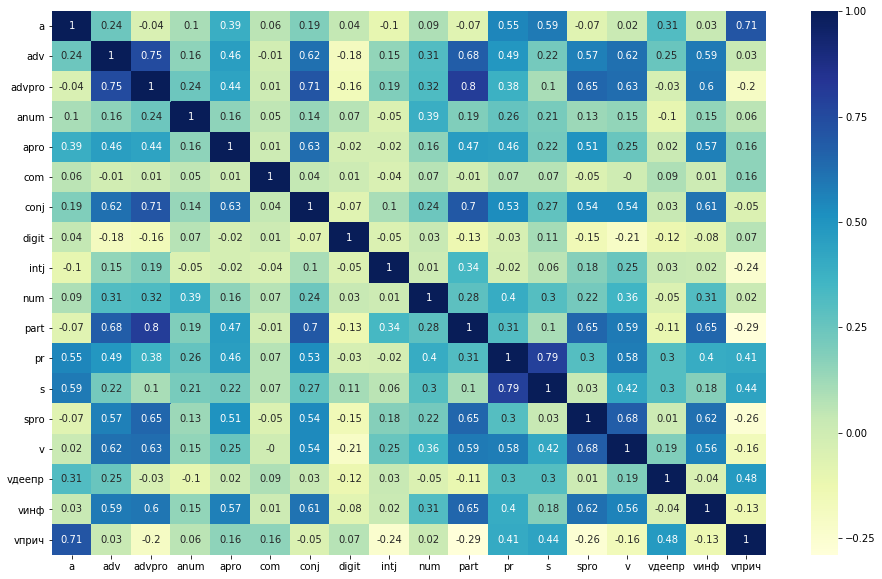

In [311]:
from seaborn import heatmap
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,10))    
df = pd.DataFrame(pos_fractions.toarray())
df.columns = sorted(cv_fractions.vocabulary_)
heatmap(df.corr().round(2), annot=True, cmap="YlGnBu")

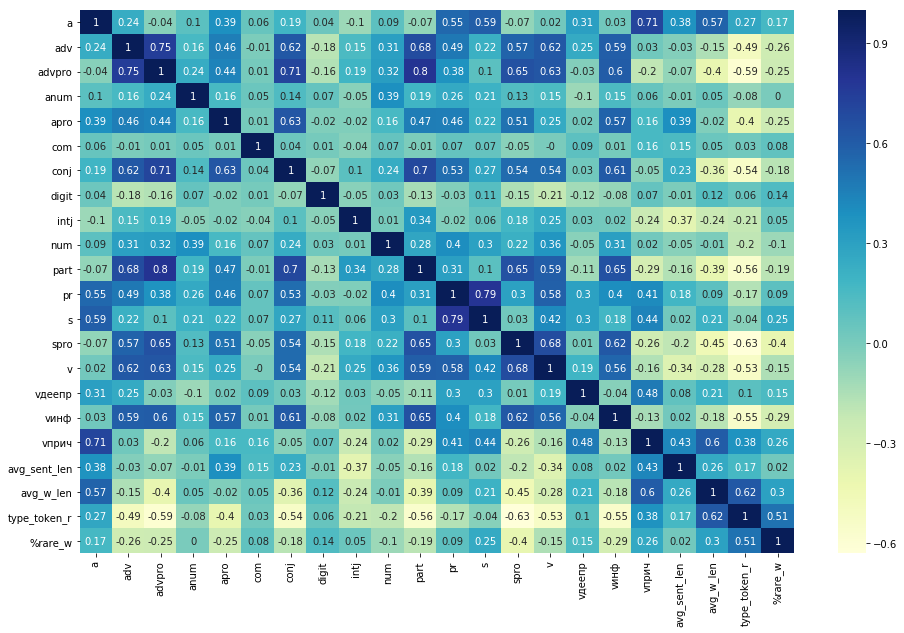

In [63]:
fig, ax = plt.subplots(figsize=(16,10))    
df = pd.DataFrame(np.c_[pos_fractions.todense(), avg_sent_l, avg_len_word, type_token_ratio, rwf])
df.columns = sorted(cv_fractions.vocabulary_)+ ['avg_sent_len', 'avg_w_len', 'type_token_r', '%rare_w']
heatmap(df.corr().round(2), annot=True, cmap="YlGnBu")